# Milestone 2: Pinecone Vector Database & Semantic Search

**Project:** Clause-AI - Legal Contract Analysis  
**Repository:** https://github.com/SentineNet-AI-SpringBoard/Clause-AI

---

## Overview

This notebook continues from Milestone 1 and covers:
- **Part 6**: Pinecone Setup + Vector Index Creation
- Vector upsert and indexing
- Semantic search implementation

### Prerequisites
- Milestone 1 completed (embeddings generated in `dataset/embeddings/`)
- Pinecone API key
- sentence-transformers model (all-MiniLM-L6-v2, 384 dimensions)

---

In [ ]:
# Milestone 2 Setup - Essential imports and paths
import os
import json
import numpy as np
from pathlib import Path

# Base directory
BASE_DIR = Path.cwd().parent if Path.cwd().name == 'notebooks' else Path.cwd()
print(f"Base directory: {BASE_DIR}")

# Load environment variables from .env (gitignored)
try:
    from dotenv import load_dotenv

    load_dotenv(dotenv_path=BASE_DIR / ".env", override=False)
    print("Loaded environment variables from .env")
except Exception:
    print("python-dotenv not available; relying on OS environment variables")

# Paths from Milestone 1
EMBEDDINGS_DIR = BASE_DIR / "dataset" / "embeddings"
CHUNKS_DIR = BASE_DIR / "dataset" / "chunks"
ARTIFACTS_DIR = BASE_DIR / "artifacts"

# Verify embeddings exist
embedding_files = list(EMBEDDINGS_DIR.glob("*_embeddings.json"))
print(f"Found {len(embedding_files)} embedding files from Milestone 1")

# Set up sentence-transformers cache
CACHE_DIR = str(BASE_DIR / "models_cache")
os.makedirs(CACHE_DIR, exist_ok=True)
os.environ['HF_HOME'] = CACHE_DIR
os.environ['SENTENCE_TRANSFORMERS_HOME'] = CACHE_DIR


Base directory: c:\Users\LENOVO\OneDrive\Dokumen\legal contracts eda\milestone2
Found 0 embedding files from Milestone 1


In [2]:
# Disable TensorFlow to avoid DLL errors
import os
os.environ['USE_TF'] = '0'
os.environ['USE_TORCH'] = '1'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Load sentence-transformers model (same as Milestone 1)
from sentence_transformers import SentenceTransformer

EMBEDDING_MODEL = "all-MiniLM-L6-v2"
EMBEDDING_DIM = 384

print(f"Loading model: {EMBEDDING_MODEL}...")
model = SentenceTransformer(EMBEDDING_MODEL, cache_folder=CACHE_DIR)
print(f"✓ Model loaded ({EMBEDDING_DIM} dimensions)")

Loading model: all-MiniLM-L6-v2...


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

c:\Users\LENOVO\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\LENOVO\OneDrive\Dokumen\legal contracts eda\milestone2\models_cache\models--sentence-transformers--all-MiniLM-L6-v2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

✓ Model loaded (384 dimensions)


---

## Part 6: Pinecone Setup + Vector Index Creation

This section covers:
1. **Install & Import Pinecone** - Setup Pinecone client
2. **Create/Connect to Index** - Create "cuad-index" with 384 dimensions
3. **Paths & Files** - Configure paths for loading embeddings
4. **Build Vectors for Upsert** - Prepare vector data with metadata
5. **Upsert First 20 Contracts** - Insert vectors into Pinecone
6. **Test Query** - Semantic search using sentence-transformers
7. **Pretty Print Top 5 Matches** - Display search results
8. **Visualization** - Similarity score distribution

**Embedding Model:** `all-MiniLM-L6-v2` (384 dimensions, same as Milestone 1)

### 6.1 Install & Import Pinecone

Install Pinecone client. Uses sentence-transformers from Part 5 for generating embeddings.

In [3]:
# Install Pinecone (new package name - pinecone, not pinecone-client)
# Run this cell ONCE, then RESTART KERNEL before proceeding
import subprocess
import sys

# Uninstall old package and install new one
try:
    subprocess.check_call([sys.executable, '-m', 'pip', 'uninstall', '-y', 'pinecone-client'], 
                          stderr=subprocess.DEVNULL, stdout=subprocess.DEVNULL)
    print("✓ Removed old pinecone-client package")
except:
    pass

subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-q', 'pinecone'])
print("✓ Installed pinecone package")
print("\n⚠️  IMPORTANT: Restart the kernel now, then skip this cell and run the next one!")

✓ Removed old pinecone-client package
✓ Installed pinecone package

⚠️  IMPORTANT: Restart the kernel now, then skip this cell and run the next one!


In [ ]:
# Pinecone Imports (run AFTER restarting kernel)
import os
import json
from pathlib import Path
from getpass import getpass

from pinecone import Pinecone, ServerlessSpec
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

# Initialize Pinecone client
PINECONE_API_KEY = (os.getenv("PINECONE_API_KEY") or "").strip()
if not PINECONE_API_KEY:
    PINECONE_API_KEY = (getpass("Enter PINECONE_API_KEY (input hidden): ") or "").strip()
if not PINECONE_API_KEY:
    raise ValueError(
        "Missing PINECONE_API_KEY. Set it as an environment variable, or re-run and enter it when prompted."
    )

pc = Pinecone(api_key=PINECONE_API_KEY)

# Embedding configuration (using sentence-transformers model from Part 5)
# Model: all-MiniLM-L6-v2 with 384 dimensions
PINECONE_EMBEDDING_DIM = 384  # Matches sentence-transformers model

print("✓ Pinecone client initialized")
print(f"Using Sentence-Transformers model from Part 5")
print(f"Embedding Dimensions: {PINECONE_EMBEDDING_DIM}")

✓ Pinecone client initialized
Using Sentence-Transformers model from Part 5
Embedding Dimensions: 384


**Output:** Confirmation that Pinecone and OpenAI clients are initialized. Make sure to set your API keys as environment variables before running.

### 6.2 Create/Connect to Index (cuad-index)

Create a new Pinecone index or connect to an existing one. Using serverless spec for cost efficiency.

In [5]:
# Index configuration
INDEX_NAME = "cuad-index"

# Check if index exists
existing_indexes = [idx.name for idx in pc.list_indexes()]
print(f"Existing indexes: {existing_indexes}")

if INDEX_NAME not in existing_indexes:
    print(f"\nCreating new index: {INDEX_NAME}")
    pc.create_index(
        name=INDEX_NAME,
        dimension=PINECONE_EMBEDDING_DIM,  # 384 for sentence-transformers
        metric="cosine",
        spec=ServerlessSpec(
            cloud="aws",
            region="us-east-1"
        )
    )
    print(f"Index '{INDEX_NAME}' created successfully!")
else:
    print(f"\nIndex '{INDEX_NAME}' already exists.")

# Connect to the index
index = pc.Index(INDEX_NAME)

# Get index stats
stats = index.describe_index_stats()
print(f"\nIndex Stats:")
print(f"  Total vectors: {stats.total_vector_count}")
print(f"  Dimension: {PINECONE_EMBEDDING_DIM}")

Existing indexes: ['cuad-index']

Index 'cuad-index' already exists.

Index Stats:
  Total vectors: 1666
  Dimension: 384


**Output:** Shows whether a new index was created or connected to an existing one. Displays current index statistics including total vector count.

### 6.3 Paths & Files

Configure paths to load chunk files from the previous processing step.

In [6]:
# Setup paths (using paths from earlier in the notebook)
BASE_DIR = Path(r"c:\Users\LENOVO\OneDrive\Dokumen\legal contracts eda")
CHUNKS_DIR = BASE_DIR / "dataset" / "chunks"
ARTIFACTS_DIR = BASE_DIR / "artifacts"

# List available chunk files
chunk_files = sorted(list(CHUNKS_DIR.glob("*_chunks.json")))
print(f"Found {len(chunk_files)} chunk files in {CHUNKS_DIR}")
print(f"\nFirst 5 files:")
for f in chunk_files[:5]:
    print(f"  - {f.name}")

Found 510 chunk files in c:\Users\LENOVO\OneDrive\Dokumen\legal contracts eda\dataset\chunks

First 5 files:
  - 2ThemartComInc_19990826_10-12G_EX-10.10_6700288_EX-10.10_Co-Branding Agreement_ Agency Agreement_chunks.json
  - ABILITYINC_06_15_2020-EX-4.25-SERVICES AGREEMENT_chunks.json
  - ACCELERATEDTECHNOLOGIESHOLDINGCORP_04_24_2003-EX-10.13-JOINT VENTURE AGREEMENT_chunks.json
  - ACCURAYINC_09_01_2010-EX-10.31-DISTRIBUTOR AGREEMENT_chunks.json
  - ADAMSGOLFINC_03_21_2005-EX-10.17-ENDORSEMENT AGREEMENT_chunks.json


**Output:** Lists available chunk files ready for embedding and upserting to Pinecone.

### 6.4 Build Vectors for Upsert

Function to generate embeddings using sentence-transformers (all-MiniLM-L6-v2) and prepare vectors with metadata for Pinecone.

In [7]:
# Using the sentence-transformers model loaded in Part 5
# Make sure you've run cell 48 first to load the model!

def get_pinecone_embeddings(texts):
    """Generate embeddings using sentence-transformers (from Part 5)."""
    embeddings = model.encode(texts, show_progress_bar=False, convert_to_numpy=True)
    return embeddings.tolist()

def build_vectors_from_chunks(chunk_file):
    """
    Load chunks from file, generate embeddings, and build Pinecone vectors.
    Returns list of vectors with metadata.
    """
    with open(chunk_file, 'r', encoding='utf-8') as f:
        data = json.load(f)
    
    contract_name = chunk_file.stem.replace('_chunks', '')
    chunks = data['chunks']
    texts = [chunk['text'] for chunk in chunks]
    
    # Generate embeddings using sentence-transformers
    embeddings = get_pinecone_embeddings(texts)
    
    # Build vectors with metadata
    vectors = []
    for i, (chunk, embedding) in enumerate(zip(chunks, embeddings)):
        vector_id = f"{contract_name}_chunk_{i}"
        metadata = {
            'contract_id': contract_name,
            'chunk_index': i,
            'text': chunk['text'][:1000],  # Truncate for metadata limit
            'char_count': len(chunk['text'])
        }
        vectors.append({
            'id': vector_id,
            'values': embedding,
            'metadata': metadata
        })
    
    return vectors

print("Vector building functions defined:")
print("  - get_pinecone_embeddings(texts): Using sentence-transformers")
print("  - build_vectors_from_chunks(chunk_file): Full pipeline")
print("\nNote: Make sure cell 48 (model loading) has been executed!")

Vector building functions defined:
  - get_pinecone_embeddings(texts): Using sentence-transformers
  - build_vectors_from_chunks(chunk_file): Full pipeline

Note: Make sure cell 48 (model loading) has been executed!


**Output:** Defines helper functions for generating sentence-transformers embeddings and building Pinecone-compatible vectors with metadata (contract_id, chunk_index, text preview, char_count).

### 6.5 Upsert First 20 Contracts (Demo)

Process the first 20 contract chunk files and upsert their vectors to Pinecone.

In [8]:
# Process and upsert first 20 contracts
MAX_CONTRACTS = 20
chunk_files_to_process = chunk_files[:MAX_CONTRACTS]

print(f"Upserting vectors from {len(chunk_files_to_process)} contracts to Pinecone")
print("=" * 60)

total_vectors = 0
upsert_stats = []

for i, chunk_file in enumerate(chunk_files_to_process):
    try:
        # Build vectors
        vectors = build_vectors_from_chunks(chunk_file)
        
        # Upsert to Pinecone in batches of 100
        batch_size = 100
        for j in range(0, len(vectors), batch_size):
            batch = vectors[j:j+batch_size]
            index.upsert(vectors=batch)
        
        contract_name = chunk_file.stem.replace('_chunks', '')[:40]
        print(f"  [{i+1}/{len(chunk_files_to_process)}] {contract_name}... ({len(vectors)} vectors)")
        
        upsert_stats.append({
            'contract': contract_name,
            'vectors': len(vectors)
        })
        total_vectors += len(vectors)
        
    except Exception as e:
        print(f"  [{i+1}] Error processing {chunk_file.name}: {str(e)[:50]}")

print("=" * 60)
print(f"Total vectors upserted: {total_vectors}")

# Verify index stats
import time
time.sleep(2)  # Wait for index to update
stats = index.describe_index_stats()
print(f"\nUpdated Index Stats:")
print(f"  Total vectors in index: {stats.total_vector_count}")

Upserting vectors from 20 contracts to Pinecone
  [1/20] 2ThemartComInc_19990826_10-12G_EX-10.10_... (39 vectors)
  [2/20] ABILITYINC_06_15_2020-EX-4.25-SERVICES A... (39 vectors)
  [3/20] ACCELERATEDTECHNOLOGIESHOLDINGCORP_04_24... (17 vectors)
  [4/20] ACCURAYINC_09_01_2010-EX-10.31-DISTRIBUT... (124 vectors)
  [5/20] ADAMSGOLFINC_03_21_2005-EX-10.17-ENDORSE... (33 vectors)
  [6/20] ADAPTIMMUNETHERAPEUTICSPLC_04_06_2017-EX... (150 vectors)
  [7/20] ADIANUTRITION,INC_04_01_2005-EX-10.D2-RE... (36 vectors)
  [8/20] ADMA BioManufacturing, LLC -  Amendment ... (25 vectors)
  [9/20] ADUROBIOTECH,INC_06_02_2020-EX-10.7-CONS... (20 vectors)
  [10/20] ADUROBIOTECH,INC_06_02_2020-EX-10.7-CONS... (20 vectors)
  [11/20] AFSALABANCORPINC_08_01_1996-EX-1.1-AGENC... (173 vectors)
  [12/20] AgapeAtpCorp_20191202_10-KA_EX-10.1_1191... (40 vectors)
  [13/20] AimmuneTherapeuticsInc_20200205_8-K_EX-1... (250 vectors)
  [14/20] AIRSPANNETWORKSINC_04_11_2000-EX-10.5-Di... (96 vectors)
  [15/20] AIRTECHIN

**Output:** Progress log showing each contract processed with vector counts. Final summary shows total vectors upserted and updated index statistics.

### 6.6 Test Query

Perform a semantic search query against the Pinecone index using a sample legal question.

In [9]:
def semantic_search(query, top_k=5):
    """
    Perform semantic search on Pinecone index.
    Returns top-k most similar chunks.
    """
    # Generate query embedding using sentence-transformers
    query_embedding = model.encode([query], convert_to_numpy=True)[0].tolist()
    
    # Query Pinecone
    results = index.query(
        vector=query_embedding,
        top_k=top_k,
        include_metadata=True
    )
    
    return results

# Test queries
test_queries = [
    "What are the termination clauses in this agreement?",
    "Indemnification and liability provisions",
    "Confidentiality and non-disclosure obligations"
]

print("Semantic Search Test")
print("=" * 60)

# Run first query as demo
query = test_queries[0]
print(f"\nQuery: '{query}'")
print("-" * 60)

results = semantic_search(query, top_k=5)

print(f"Found {len(results.matches)} matches\n")
for i, match in enumerate(results.matches):
    score = match.score
    contract = match.metadata.get('contract_id', 'Unknown')[:40]
    chunk_idx = match.metadata.get('chunk_index', 0)
    print(f"  {i+1}. Score: {score:.4f} | Contract: {contract}... | Chunk: {chunk_idx}")

Semantic Search Test

Query: 'What are the termination clauses in this agreement?'
------------------------------------------------------------
Found 5 matches

  1. Score: 0.7474 | Contract: AIRSPANNETWORKSINC_04_11_2000-EX-10.5-Di... | Chunk: 56.0
  2. Score: 0.7469 | Contract: AlliedEsportsEntertainmentInc_20190815_8... | Chunk: 38.0
  3. Score: 0.7262 | Contract: AlliedEsportsEntertainmentInc_20190815_8... | Chunk: 39.0
  4. Score: 0.7196 | Contract: 2ThemartComInc_19990826_10-12G_EX-10.10_... | Chunk: 23.0
  5. Score: 0.7181 | Contract: ABILITYINC_06_15_2020-EX-4.25-SERVICES A... | Chunk: 15.0


**Output:** Shows top 5 matching chunks with similarity scores. Higher scores indicate more semantically similar content to the query.

### 6.7 Pretty Print Top 5 Matches

Display detailed results for the top 5 matches including the actual text content.

In [10]:
def pretty_print_results(query, results, max_text_len=300):
    """Pretty print search results with formatted output."""
    print("=" * 80)
    print(f"QUERY: {query}")
    print("=" * 80)
    print()
    
    for i, match in enumerate(results.matches):
        score = match.score
        metadata = match.metadata
        contract = metadata.get('contract_id', 'Unknown')
        chunk_idx = metadata.get('chunk_index', 0)
        char_count = metadata.get('char_count', 0)
        text = metadata.get('text', '')[:max_text_len]
        
        print(f"Match {i+1} of {len(results.matches)}")
        print("-" * 80)
        print(f"  Similarity Score: {score:.4f}")
        print(f"  Contract: {contract}")
        print(f"  Chunk Index: {chunk_idx}")
        print(f"  Character Count: {char_count}")
        print()
        print(f"  Text Preview:")
        print(f"  {'-' * 70}")
        # Wrap text for better display
        wrapped_text = text.replace('\n', ' ')
        print(f"  {wrapped_text}...")
        print()

# Pretty print results for the first query
query = "What are the termination clauses in this agreement?"
results = semantic_search(query, top_k=5)
pretty_print_results(query, results)

QUERY: What are the termination clauses in this agreement?

Match 1 of 5
--------------------------------------------------------------------------------
  Similarity Score: 0.7474
  Contract: AIRSPANNETWORKSINC_04_11_2000-EX-10.5-Distributor Agreement
  Chunk Index: 56.0
  Character Count: 690.0

  Text Preview:
  ----------------------------------------------------------------------
  13.2 Either party may terminate this Agreement at any time during the term of this Agreement if either party fails materially to comply with any covenant, term, or provision of this Agreement, by written notice given to the other party not less than thirty (30) days prior to the effective date of su...

Match 2 of 5
--------------------------------------------------------------------------------
  Similarity Score: 0.7469
  Contract: AlliedEsportsEntertainmentInc_20190815_8-K_EX-10.19_11788293_EX-10.19_Content License Agreement
  Chunk Index: 38.0
  Character Count: 893.0

  Text Preview:
  ------------

**Output:** Formatted display of top 5 matches showing similarity score, contract name, chunk index, and a preview of the matching text content.

### 6.8 Visualization: Similarity Score Distribution

Visualize the distribution of similarity scores across multiple queries to understand the search quality.

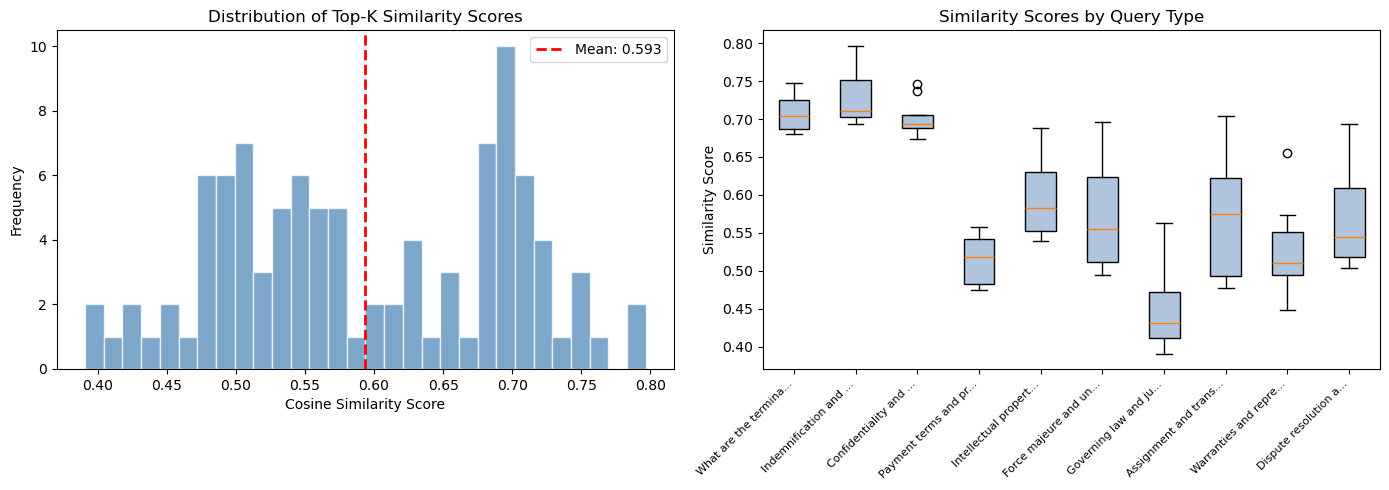


Similarity Score Statistics
Total queries: 10
Total matches analyzed: 100
Mean score: 0.5934
Std deviation: 0.1013
Min score: 0.3909
Max score: 0.7966


In [11]:
# Run multiple queries and collect similarity scores
test_queries = [
    "What are the termination clauses in this agreement?",
    "Indemnification and liability provisions",
    "Confidentiality and non-disclosure obligations",
    "Payment terms and pricing",
    "Intellectual property rights",
    "Force majeure and unforeseen circumstances",
    "Governing law and jurisdiction",
    "Assignment and transfer of rights",
    "Warranties and representations",
    "Dispute resolution and arbitration"
]

all_scores = []
query_labels = []

for query in test_queries:
    results = semantic_search(query, top_k=10)
    for match in results.matches:
        all_scores.append(match.score)
        query_labels.append(query[:30] + "...")

# Create visualizations
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram of all scores
ax1 = axes[0]
ax1.hist(all_scores, bins=30, color='steelblue', edgecolor='white', alpha=0.7)
mean_score = np.mean(all_scores)
ax1.axvline(mean_score, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_score:.3f}')
ax1.set_xlabel('Cosine Similarity Score')
ax1.set_ylabel('Frequency')
ax1.set_title('Distribution of Top-K Similarity Scores')
ax1.legend()

# Box plot by query
ax2 = axes[1]
scores_by_query = {}
for query in test_queries:
    results = semantic_search(query, top_k=10)
    scores = [match.score for match in results.matches]
    short_query = query[:20] + "..."
    scores_by_query[short_query] = scores

# Create box plot
positions = range(len(scores_by_query))
bp = ax2.boxplot(scores_by_query.values(), positions=positions, patch_artist=True)
for patch in bp['boxes']:
    patch.set_facecolor('lightsteelblue')
ax2.set_xticks(positions)
ax2.set_xticklabels(scores_by_query.keys(), rotation=45, ha='right', fontsize=8)
ax2.set_ylabel('Similarity Score')
ax2.set_title('Similarity Scores by Query Type')

plt.tight_layout()
plt.savefig(ARTIFACTS_DIR / 'pinecone_similarity_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

# Summary statistics
print("\nSimilarity Score Statistics")
print("=" * 40)
print(f"Total queries: {len(test_queries)}")
print(f"Total matches analyzed: {len(all_scores)}")
print(f"Mean score: {np.mean(all_scores):.4f}")
print(f"Std deviation: {np.std(all_scores):.4f}")
print(f"Min score: {min(all_scores):.4f}")
print(f"Max score: {max(all_scores):.4f}")

**Output:** Two visualizations:
1. **Histogram**: Overall distribution of similarity scores across all queries
2. **Box Plot**: Score distribution by query type to compare retrieval quality

The visualization is saved to `artifacts/pinecone_similarity_distribution.png`. Summary statistics show mean, standard deviation, and range of scores.

---

## Part 7: Building the Retrieval (RAG) Search Wrapper

This section creates reusable RAG modules for agent integration:
1. **Query Pinecone** using text input
2. **Fetch top-k** relevant chunks
3. **Highlight matching text**
4. **Visualize similarity scores**

These modules will be used for building downstream AI agents.

### 7.1 Imports for RAG Module

In [12]:
# RAG Module Imports
import re
from datetime import datetime
from typing import List, Dict, Optional
from dataclasses import dataclass, asdict

# For visualization
import matplotlib.pyplot as plt

print("RAG module imports loaded successfully")

RAG module imports loaded successfully


### 7.2 Helper: Embed a Query

Function to convert text query to embedding vector using sentence-transformers.

In [13]:
def embed_query(query: str) -> List[float]:
    """
    Convert a text query to an embedding vector using sentence-transformers.
    
    Args:
        query: The text query to embed
        
    Returns:
        List of floats representing the 384-dimensional embedding vector
    """
    # Use the model loaded at the start of the notebook
    embedding = model.encode([query], convert_to_numpy=True)[0]
    return embedding.tolist()

# Test the function
test_query = "What are the termination clauses in this agreement?"
test_embedding = embed_query(test_query)
print(f"Query: '{test_query}'")
print(f"Embedding dimension: {len(test_embedding)}")
print(f"First 5 values: {test_embedding[:5]}")

Query: 'What are the termination clauses in this agreement?'
Embedding dimension: 384
First 5 values: [-0.01803308166563511, 0.14082063734531403, 0.0725383311510086, -0.027526311576366425, 0.007633693981915712]


### 7.3 RAG Search Function

Core retrieval function that queries Pinecone and returns relevant chunks with metadata.

In [14]:
@dataclass
class RAGResult:
    """Data class to hold a single RAG search result."""
    rank: int
    score: float
    contract_id: str
    chunk_index: int
    text: str
    char_count: int
    
    def to_dict(self) -> Dict:
        return asdict(self)


@dataclass 
class RAGSearchResponse:
    """Data class to hold the complete RAG search response."""
    query: str
    timestamp: str
    total_results: int
    results: List[RAGResult]
    
    def to_dict(self) -> Dict:
        return {
            'query': self.query,
            'timestamp': self.timestamp,
            'total_results': self.total_results,
            'results': [r.to_dict() for r in self.results]
        }


def rag_search(
    query: str,
    top_k: int = 5,
    include_metadata: bool = True,
    min_score: float = 0.0
) -> RAGSearchResponse:
    """
    Perform RAG search: embed query, search Pinecone, return relevant chunks.
    
    Args:
        query: The natural language query
        top_k: Number of results to return
        include_metadata: Whether to include chunk metadata
        min_score: Minimum similarity score threshold
        
    Returns:
        RAGSearchResponse object with query results
    """
    # Embed the query
    query_vector = embed_query(query)
    
    # Query Pinecone
    results = index.query(
        vector=query_vector,
        top_k=top_k,
        include_metadata=include_metadata
    )
    
    # Parse results
    rag_results = []
    for rank, match in enumerate(results.matches, 1):
        if match.score >= min_score:
            metadata = match.metadata or {}
            rag_results.append(RAGResult(
                rank=rank,
                score=float(match.score),
                contract_id=metadata.get('contract_id', 'Unknown'),
                chunk_index=metadata.get('chunk_index', -1),
                text=metadata.get('text', ''),
                char_count=metadata.get('char_count', 0)
            ))
    
    return RAGSearchResponse(
        query=query,
        timestamp=datetime.now().isoformat(),
        total_results=len(rag_results),
        results=rag_results
    )

print("RAG search function defined successfully")

RAG search function defined successfully


### 7.4 Pretty Print Results

Display search results in a formatted, readable output.

In [15]:
def pretty_print_results(response: RAGSearchResponse, max_text_length: int = 300) -> None:
    """
    Pretty print RAG search results.
    
    Args:
        response: RAGSearchResponse object
        max_text_length: Maximum characters to display per chunk
    """
    print("=" * 80)
    print(f"🔍 RAG SEARCH RESULTS")
    print("=" * 80)
    print(f"Query: \"{response.query}\"")
    print(f"Timestamp: {response.timestamp}")
    print(f"Total Results: {response.total_results}")
    print("-" * 80)
    
    if not response.results:
        print("No results found.")
        return
    
    for result in response.results:
        print(f"\n📄 RANK #{result.rank} | Score: {result.score:.4f}")
        print(f"   Contract: {result.contract_id[:60]}...")
        print(f"   Chunk Index: {result.chunk_index} | Characters: {result.char_count}")
        print(f"   Text Preview:")
        
        # Truncate text if needed
        text = result.text
        if len(text) > max_text_length:
            text = text[:max_text_length] + "..."
        
        # Indent text
        for line in text.split('\n'):
            print(f"      {line}")
        
        print("-" * 80)

print("Pretty print function defined successfully")

Pretty print function defined successfully


### 7.5 Test with Real Legal Queries

Test the RAG search with common legal contract queries.

In [16]:
# Test with multiple legal queries
legal_queries = [
    "What are the termination clauses and conditions?",
    "What happens in case of breach of contract?",
    "What are the confidentiality and non-disclosure obligations?",
    "What are the payment terms and conditions?",
    "What is the governing law and jurisdiction?",
    "What are the indemnification and hold harmless obligations?",
]

# Run search for the first query
print("Testing RAG Search with a legal query...\n")
response = rag_search(legal_queries[0], top_k=5)
pretty_print_results(response)

Testing RAG Search with a legal query...

🔍 RAG SEARCH RESULTS
Query: "What are the termination clauses and conditions?"
Timestamp: 2026-01-09T18:42:17.692434
Total Results: 5
--------------------------------------------------------------------------------

📄 RANK #1 | Score: 0.7244
   Contract: AlliedEsportsEntertainmentInc_20190815_8-K_EX-10.19_11788293...
   Chunk Index: 38.0 | Characters: 893.0
   Text Preview:
      . 6. TERMINATION a. Each party shall have the right at any time to terminate this Agreement without prejudice to any rights which it may have, whether pursuant to the provisions of this Agreement or otherwise in law or in equity or otherwise, upon the occurrence of any one or more of the following e...
--------------------------------------------------------------------------------

📄 RANK #2 | Score: 0.6625
   Contract: AlliedEsportsEntertainmentInc_20190815_8-K_EX-10.19_11788293...
   Chunk Index: 39.0 | Characters: 842.0
   Text Preview:
      . The other party asse

### 7.6 Highlight Keywords in Retrieved Chunks

Function to highlight matching keywords in the retrieved text chunks.

In [17]:
def highlight_keywords(text: str, keywords: List[str], marker: str = "**") -> str:
    """
    Highlight keywords in text by wrapping them with markers.
    
    Args:
        text: The text to highlight
        keywords: List of keywords to highlight
        marker: The marker to wrap keywords with (default: **)
        
    Returns:
        Text with highlighted keywords
    """
    highlighted = text
    for keyword in keywords:
        # Case-insensitive replacement
        pattern = re.compile(re.escape(keyword), re.IGNORECASE)
        highlighted = pattern.sub(f"{marker}{keyword.upper()}{marker}", highlighted)
    return highlighted


def extract_query_keywords(query: str, min_length: int = 3) -> List[str]:
    """
    Extract meaningful keywords from a query.
    
    Args:
        query: The search query
        min_length: Minimum keyword length
        
    Returns:
        List of keywords
    """
    # Common stop words to filter
    stop_words = {
        'the', 'and', 'are', 'what', 'how', 'when', 'where', 'which', 
        'this', 'that', 'these', 'those', 'for', 'with', 'has', 'have',
        'been', 'being', 'was', 'were', 'will', 'would', 'could', 'should'
    }
    
    # Extract words and filter
    words = re.findall(r'\b[a-zA-Z]+\b', query.lower())
    keywords = [w for w in words if len(w) >= min_length and w not in stop_words]
    
    return list(set(keywords))


def pretty_print_with_highlights(response: RAGSearchResponse, max_text_length: int = 400) -> None:
    """
    Pretty print results with keyword highlighting.
    """
    keywords = extract_query_keywords(response.query)
    
    print("=" * 80)
    print(f"🔍 RAG SEARCH RESULTS (with highlights)")
    print("=" * 80)
    print(f"Query: \"{response.query}\"")
    print(f"Keywords: {keywords}")
    print(f"Total Results: {response.total_results}")
    print("-" * 80)
    
    for result in response.results:
        print(f"\n📄 RANK #{result.rank} | Score: {result.score:.4f}")
        print(f"   Contract: {result.contract_id[:50]}...")
        
        # Highlight keywords in text
        text = result.text[:max_text_length]
        if len(result.text) > max_text_length:
            text += "..."
        
        highlighted_text = highlight_keywords(text, keywords, marker=">>")
        print(f"   Text (highlighted):")
        for line in highlighted_text.split('\n')[:5]:  # Limit lines
            print(f"      {line}")
        
        print("-" * 80)

# Test highlighting
print("Testing keyword highlighting...\n")
if response.results:
    pretty_print_with_highlights(response)

Testing keyword highlighting...

🔍 RAG SEARCH RESULTS (with highlights)
Query: "What are the termination clauses and conditions?"
Keywords: ['conditions', 'clauses', 'termination']
Total Results: 5
--------------------------------------------------------------------------------

📄 RANK #1 | Score: 0.7244
   Contract: AlliedEsportsEntertainmentInc_20190815_8-K_EX-10.1...
   Text (highlighted):
      . 6. >>TERMINATION>> a. Each party shall have the right at any time to terminate this Agreement without prejudice to any rights which it may have, whether pursuant to the provisions of this Agreement or otherwise in law or in equity or otherwise, upon the occurrence of any one or more of the following events: i. The other party breaches or fails to perform any of its material obligations provided for ...
--------------------------------------------------------------------------------

📄 RANK #2 | Score: 0.6625
   Contract: AlliedEsportsEntertainmentInc_20190815_8-K_EX-10.1...
   Text (highli

### 7.7 Visualize Similarity Scores

Visualize the similarity score distribution for search results.

Figure saved to: c:\Users\LENOVO\OneDrive\Dokumen\legal contracts eda\artifacts\rag_search_scores.png


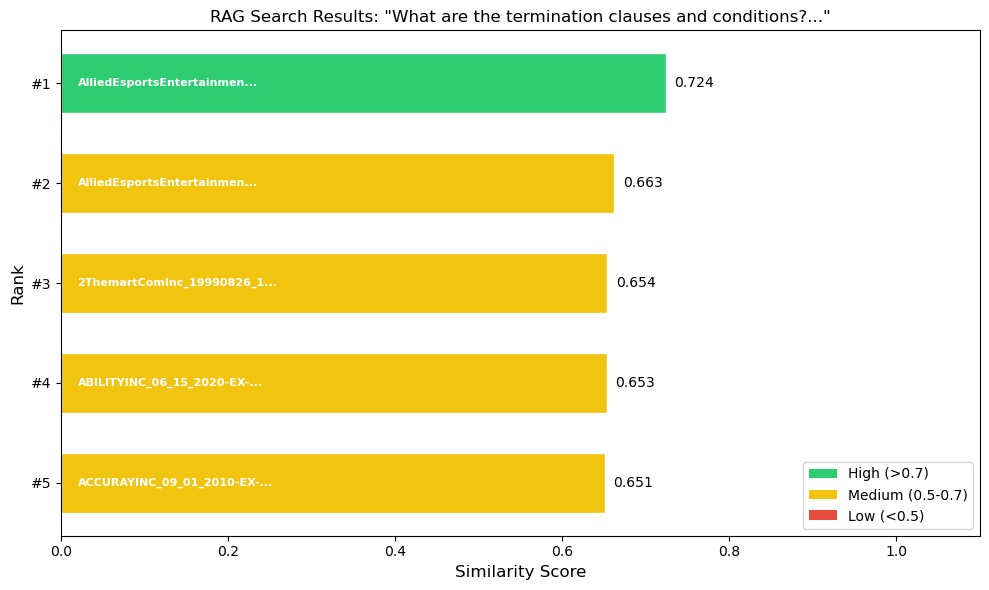

In [18]:
def visualize_search_scores(response: RAGSearchResponse, save_path: Optional[str] = None) -> None:
    """
    Create a bar chart visualization of similarity scores.
    
    Args:
        response: RAGSearchResponse object
        save_path: Optional path to save the figure
    """
    if not response.results:
        print("No results to visualize")
        return
    
    # Extract data
    ranks = [f"#{r.rank}" for r in response.results]
    scores = [r.score for r in response.results]
    contracts = [r.contract_id[:25] + "..." for r in response.results]
    
    # Create figure
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Color bars based on score
    colors = ['#2ecc71' if s > 0.7 else '#f1c40f' if s > 0.5 else '#e74c3c' for s in scores]
    
    bars = ax.barh(ranks, scores, color=colors, edgecolor='white', height=0.6)
    
    # Add score labels
    for bar, score, contract in zip(bars, scores, contracts):
        ax.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2,
                f'{score:.3f}', va='center', fontsize=10)
        ax.text(0.02, bar.get_y() + bar.get_height()/2,
                contract, va='center', fontsize=8, color='white', fontweight='bold')
    
    ax.set_xlabel('Similarity Score', fontsize=12)
    ax.set_ylabel('Rank', fontsize=12)
    ax.set_title(f'RAG Search Results: "{response.query[:50]}..."', fontsize=12)
    ax.set_xlim(0, 1.1)
    ax.invert_yaxis()
    
    # Add legend
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='#2ecc71', label='High (>0.7)'),
        Patch(facecolor='#f1c40f', label='Medium (0.5-0.7)'),
        Patch(facecolor='#e74c3c', label='Low (<0.5)')
    ]
    ax.legend(handles=legend_elements, loc='lower right')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"Figure saved to: {save_path}")
    
    plt.show()

# Visualize the previous search results
if response.results:
    visualize_search_scores(response, save_path=str(ARTIFACTS_DIR / 'rag_search_scores.png'))

### 7.8 Save Results to JSON

Export RAG search results to JSON for downstream agent processing.

In [19]:
def save_search_results(response: RAGSearchResponse, filepath: str) -> None:
    """
    Save RAG search results to a JSON file.
    
    Args:
        response: RAGSearchResponse object
        filepath: Path to save the JSON file
    """
    with open(filepath, 'w', encoding='utf-8') as f:
        json.dump(response.to_dict(), f, indent=2, ensure_ascii=False)
    print(f"Results saved to: {filepath}")


def batch_search_and_save(
    queries: List[str], 
    output_dir: str,
    top_k: int = 5
) -> Dict[str, RAGSearchResponse]:
    """
    Run multiple queries and save results.
    
    Args:
        queries: List of search queries
        output_dir: Directory to save results
        top_k: Number of results per query
        
    Returns:
        Dictionary mapping queries to their responses
    """
    import os
    os.makedirs(output_dir, exist_ok=True)
    
    all_responses = {}
    
    for i, query in enumerate(queries, 1):
        print(f"[{i}/{len(queries)}] Searching: {query[:50]}...")
        response = rag_search(query, top_k=top_k)
        all_responses[query] = response
        
        # Save individual result
        safe_name = re.sub(r'[^\w\s-]', '', query)[:50].strip().replace(' ', '_')
        filepath = os.path.join(output_dir, f"search_{i:02d}_{safe_name}.json")
        save_search_results(response, filepath)
    
    print(f"\n✓ Saved {len(queries)} search results to {output_dir}")
    return all_responses

# Test saving results
if response.results:
    save_search_results(response, str(ARTIFACTS_DIR / 'rag_search_example.json'))

Results saved to: c:\Users\LENOVO\OneDrive\Dokumen\legal contracts eda\artifacts\rag_search_example.json


### 7.9 Batch Test All Legal Queries

Run all predefined legal queries and save results for agent integration.

In [20]:
# Run batch search on all legal queries
RAG_RESULTS_DIR = ARTIFACTS_DIR / "rag_results"
all_responses = batch_search_and_save(
    queries=legal_queries,
    output_dir=str(RAG_RESULTS_DIR),
    top_k=5
)

# Summary statistics
print("\n" + "=" * 60)
print("RAG Search Summary")
print("=" * 60)
for query, resp in all_responses.items():
    avg_score = sum(r.score for r in resp.results) / len(resp.results) if resp.results else 0
    print(f"  Query: {query[:45]}...")
    print(f"    Results: {resp.total_results} | Avg Score: {avg_score:.4f}")
    print()

[1/6] Searching: What are the termination clauses and conditions?...
Results saved to: c:\Users\LENOVO\OneDrive\Dokumen\legal contracts eda\artifacts\rag_results\search_01_What_are_the_termination_clauses_and_conditions.json
[2/6] Searching: What happens in case of breach of contract?...
Results saved to: c:\Users\LENOVO\OneDrive\Dokumen\legal contracts eda\artifacts\rag_results\search_02_What_happens_in_case_of_breach_of_contract.json
[3/6] Searching: What are the confidentiality and non-disclosure ob...
Results saved to: c:\Users\LENOVO\OneDrive\Dokumen\legal contracts eda\artifacts\rag_results\search_03_What_are_the_confidentiality_and_non-disclosure_ob.json
[4/6] Searching: What are the payment terms and conditions?...
Results saved to: c:\Users\LENOVO\OneDrive\Dokumen\legal contracts eda\artifacts\rag_results\search_04_What_are_the_payment_terms_and_conditions.json
[5/6] Searching: What is the governing law and jurisdiction?...
Results saved to: c:\Users\LENOVO\OneDrive\Dokumen\le

---

## Part 8: Agent Framework Setup + Standard Output Schema

Before creating individual agents (Legal, Compliance, Finance, Operations), we must build a common foundation:
1. **Define Standard Output Schema** - Consistent agent response format
2. **Build Reusable Base Agent Class** - Common interface for all agents
3. **JSON Validation Helper** - Validate agent outputs before use
4. **Example Agent Prompt** - Template for Legal Agent

**LLM Backend:** Hugging Face - google/gemma-2b-it (Local inference)

### 8.1 Install Hugging Face Transformers

Install the required packages for running Gemma 2B locally.

In [21]:
# Install Hugging Face Transformers and Accelerate for Gemma 2B
import subprocess
import sys

packages = ['transformers', 'accelerate', 'bitsandbytes']
for pkg in packages:
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-q', pkg])
    
print("✓ Hugging Face Transformers installed")
print("✓ Accelerate installed")
print("✓ Bitsandbytes installed (for quantization)")
print("\nNote: You may need a Hugging Face token to access Gemma 2B")
print("Get your token at: https://huggingface.co/settings/tokens")

✓ Hugging Face Transformers installed
✓ Accelerate installed
✓ Bitsandbytes installed (for quantization)

Note: You may need a Hugging Face token to access Gemma 2B
Get your token at: https://huggingface.co/settings/tokens


### 8.2 Define Standard Output Schema

All agents must return responses in this consistent format for downstream processing.

In [22]:
# Standard Agent Output Schema
# All agents must return responses in this format

AGENT_OUTPUT_SCHEMA = {
    "clause_type": "",           # Type of clause analyzed (e.g., "Termination", "Confidentiality")
    "extracted_clauses": [],     # List of extracted clause texts
    "risk_level": "unknown",     # "low" | "medium" | "high" | "unknown"
    "confidence": 0.0,           # Confidence score (0.0 - 1.0)
    "evidence": []               # List of exact sentences from contract supporting the analysis
}

print("Standard Agent Output Schema:")
print("-" * 50)
for key, default_value in AGENT_OUTPUT_SCHEMA.items():
    print(f"  {key}: {type(default_value).__name__} = {default_value}")

Standard Agent Output Schema:
--------------------------------------------------
  clause_type: str = 
  extracted_clauses: list = []
  risk_level: str = unknown
  confidence: float = 0.0
  evidence: list = []


### 8.3 Base Agent Class

Reusable agent base class using Hugging Face Gemma 2B model.

In [ ]:
# Disable TensorFlow completely (we're using PyTorch only)
import os
os.environ['USE_TF'] = '0'
os.environ['USE_TORCH'] = '1'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['TRANSFORMERS_NO_TF'] = '1'

import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
import json
from typing import Dict, Any, Optional
from getpass import getpass

# Hugging Face token (optional; needed for gated models / higher rate limits)
# Never hardcode tokens in notebooks; use environment variables instead.
HF_TOKEN = os.getenv("HF_TOKEN") or os.getenv("HUGGINGFACEHUB_API_TOKEN")

# If not set, you can paste it securely (not echoed). Press Enter to skip.
if HF_TOKEN is None:
    try:
        _tmp = getpass("HF_TOKEN (optional; press Enter to skip): ").strip()
        HF_TOKEN = _tmp or None
    except Exception:
        HF_TOKEN = None

_token_kwargs = {"token": HF_TOKEN} if HF_TOKEN else {}

# Model configuration
MODEL_NAME = "google/gemma-2b-it"

print(f"Loading model: {MODEL_NAME}")
print("This may take a few minutes on first run...")

# Check if CUDA is available
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# Quantization config for memory efficiency (optional, for GPU)
if device == "cuda":
    quantization_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_compute_dtype=torch.float16
    )
    print("Using 4-bit quantization for memory efficiency")
else:
    quantization_config = None
    print("Running on CPU (will be slower)")

# Load tokenizer
print("\nLoading tokenizer...")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, **_token_kwargs)
print("✓ Tokenizer loaded")

# Load model
print("Loading model weights (this may take a while on CPU)...")
if quantization_config:
    gemma_model = AutoModelForCausalLM.from_pretrained(
        MODEL_NAME,
        quantization_config=quantization_config,
        device_map="auto",
        **_token_kwargs,
    )
else:
    gemma_model = AutoModelForCausalLM.from_pretrained(
        MODEL_NAME,
        torch_dtype=torch.float32,
        low_cpu_mem_usage=True,
        **_token_kwargs,
    ).to(device)

print(f"\n✓ Model loaded: {MODEL_NAME}")


class BaseAgent:
    """
    Base class for all contract analysis agents.
    Uses Hugging Face Gemma 2B for LLM inference.
    """

    def __init__(self, agent_name: str, system_prompt: str):
        self.agent_name = agent_name
        self.system_prompt = system_prompt
        self.model = gemma_model
        self.tokenizer = tokenizer
        self.device = device

    def run(self, context_text: str, max_new_tokens: int = 512) -> str:
        """
        Run the agent on the given context text.
        """
        # Simplified prompt for better response
        full_prompt = f"""<bos><start_of_turn>user
{self.system_prompt}

CONTRACT TEXT:
{context_text[:1500]}
<end_of_turn>
<start_of_turn>model
"""

        # Tokenize
        inputs = self.tokenizer(full_prompt, return_tensors="pt", truncation=True, max_length=2048).to(self.device)
        prompt_length = inputs['input_ids'].shape[1]

        # Generate
        with torch.no_grad():
            outputs = self.model.generate(
                **inputs,
                max_new_tokens=max_new_tokens,
                temperature=0.2,
                do_sample=True,
                top_p=0.9,
                pad_token_id=self.tokenizer.eos_token_id,
                eos_token_id=self.tokenizer.eos_token_id
            )

        # Extract ONLY the newly generated tokens (exclude the prompt)
        new_tokens = outputs[0][prompt_length:]
        response = self.tokenizer.decode(new_tokens, skip_special_tokens=True)

        return response.strip()

    def __repr__(self):
        return f"BaseAgent(name='{self.agent_name}', model='{MODEL_NAME}')"


print(f"\n✓ BaseAgent class defined")
print(f"  Model: {MODEL_NAME}")
print(f"  Device: {device}")


Loading model: google/gemma-2b-it
This may take a few minutes on first run...
Using device: cpu
Running on CPU (will be slower)

Loading tokenizer...


tokenizer_config.json:   0%|          | 0.00/34.2k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

✓ Tokenizer loaded
Loading model weights (this may take a while on CPU)...


config.json:   0%|          | 0.00/627 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors.index.json:   0%|          | 0.00/13.5k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model-00002-of-00002.safetensors:   0%|          | 0.00/67.1M [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]


✓ Model loaded: google/gemma-2b-it

✓ BaseAgent class defined
  Model: google/gemma-2b-it
  Device: cpu


### 8.4 JSON Validation Helper

Validates agent output against the standard schema.

In [24]:
def repair_json_string(json_str: str) -> str:
    """
    Attempt to repair common JSON issues from LLM outputs.
    """
    import re
    
    # Remove any trailing text after the last }
    last_brace = json_str.rfind('}')
    if last_brace != -1:
        json_str = json_str[:last_brace + 1]
    
    # Fix missing closing quotes before ] or ,
    # Pattern: "text without closing quote], or "text without closing quote",
    json_str = re.sub(r'(\["[^"]*?)(\],)', r'\1"\2', json_str)
    json_str = re.sub(r'(\["[^"]*?)(,\s*")', r'\1"\2', json_str)
    json_str = re.sub(r'(":\s*"[^"]*?)(\s*[,}])', lambda m: m.group(1) + '"' + m.group(2) if m.group(1).count('"') % 2 == 1 else m.group(0), json_str)
    
    # Fix missing quotes around values
    json_str = re.sub(r':\s*([a-zA-Z_][a-zA-Z0-9_]*)\s*([,}])', r': "\1"\2', json_str)
    
    # Count and fix bracket mismatches
    open_braces = json_str.count('{') - json_str.count('}')
    open_brackets = json_str.count('[') - json_str.count(']')
    
    # Check for unclosed strings
    in_string = False
    escape_next = False
    for i, char in enumerate(json_str):
        if escape_next:
            escape_next = False
            continue
        if char == '\\':
            escape_next = True
            continue
        if char == '"':
            in_string = not in_string
    
    # If we ended inside a string, close it
    if in_string:
        json_str = json_str.rstrip()
        # Find the last sensible place to close the string
        if json_str.endswith(','):
            json_str = json_str[:-1] + '",'
        elif json_str.endswith('['):
            json_str += '"]'
        else:
            json_str += '"'
    
    # Close any unclosed brackets/braces
    json_str += ']' * max(0, open_brackets)
    json_str += '}' * max(0, open_braces)
    
    return json_str


def extract_json_from_response(raw_response: str) -> Optional[Dict]:
    """
    Extract JSON from LLM response with robust error handling and repair.
    Handles: markdown blocks, truncated JSON, missing quotes, malformed strings.
    
    Args:
        raw_response: Raw text response from LLM
        
    Returns:
        Parsed JSON dict or None if parsing fails
    """
    import re
    
    # Clean up common issues
    text = raw_response.strip()
    
    # Method 1: Try to extract JSON from markdown code block
    json_match = re.search(r'```(?:json)?\s*([\s\S]*?)\s*```', text)
    if json_match:
        json_str = json_match.group(1).strip()
        try:
            return json.loads(json_str)
        except json.JSONDecodeError:
            # Try repairing the markdown JSON
            try:
                repaired = repair_json_string(json_str)
                return json.loads(repaired)
            except json.JSONDecodeError:
                pass
    
    # Method 2: Find JSON object and try to parse
    start_idx = text.find('{')
    if start_idx != -1:
        # Extract from { to the end
        json_candidate = text[start_idx:]
        
        # Try parsing as-is first
        try:
            # Find matching closing brace
            bracket_count = 0
            for i, char in enumerate(json_candidate):
                if char == '{':
                    bracket_count += 1
                elif char == '}':
                    bracket_count -= 1
                    if bracket_count == 0:
                        complete_json = json_candidate[:i+1]
                        return json.loads(complete_json)
        except json.JSONDecodeError:
            pass
        
        # Method 3: Try repairing the JSON
        try:
            repaired = repair_json_string(json_candidate)
            return json.loads(repaired)
        except json.JSONDecodeError:
            pass
        
        # Method 4: More aggressive repair - extract key-value pairs manually
        try:
            # Try to extract the core structure
            extracted_clauses = re.findall(r'"extracted_clauses"\s*:\s*\[(.*?)\]', json_candidate, re.DOTALL)
            risk_level = re.search(r'"risk_level"\s*:\s*"(\w+)"', json_candidate)
            confidence = re.search(r'"confidence"\s*:\s*([\d.]+)', json_candidate)
            evidence = re.findall(r'"evidence"\s*:\s*\[(.*?)\]', json_candidate, re.DOTALL)
            
            if extracted_clauses or risk_level or confidence:
                result = {
                    "extracted_clauses": [],
                    "risk_level": "unknown",
                    "confidence": 0.0,
                    "evidence": []
                }
                
                if extracted_clauses:
                    # Parse clauses from the array content
                    clauses_str = extracted_clauses[0]
                    # Find quoted strings
                    clauses = re.findall(r'"([^"]*)"', clauses_str)
                    result["extracted_clauses"] = clauses if clauses else [clauses_str.strip()]
                
                if risk_level:
                    result["risk_level"] = risk_level.group(1).lower()
                
                if confidence:
                    try:
                        result["confidence"] = float(confidence.group(1))
                    except:
                        pass
                
                if evidence:
                    evidence_str = evidence[0]
                    evidence_items = re.findall(r'"([^"]*)"', evidence_str)
                    result["evidence"] = evidence_items
                
                return result
        except Exception:
            pass
    
    # Method 5: Try parsing the entire response as JSON
    try:
        return json.loads(text)
    except json.JSONDecodeError:
        pass
    
    return None


def validate_agent_output(raw_output: str, clause_type: str = "Unknown", debug: bool = False) -> Dict[str, Any]:
    """
    Validate and normalize agent output against the standard schema.
    
    Args:
        raw_output: Raw text response from agent
        clause_type: Type of clause being analyzed
        debug: If True, print debug information
        
    Returns:
        Validated output dict matching AGENT_OUTPUT_SCHEMA
    """
    # Parse JSON from response
    parsed = extract_json_from_response(raw_output)
    
    if debug:
        print(f"Debug - Raw output length: {len(raw_output)}")
        print(f"Debug - Parsed result: {parsed is not None}")
        if parsed:
            print(f"Debug - Parsed keys: {list(parsed.keys())}")
    
    # Start with default schema
    validated = AGENT_OUTPUT_SCHEMA.copy()
    validated["clause_type"] = clause_type
    
    if parsed is None:
        print(f"⚠️  Warning: Could not parse JSON from agent response")
        print(f"   Raw output preview: {raw_output[:200]}...")
        validated["extracted_clauses"] = [raw_output[:500] + "..." if len(raw_output) > 500 else raw_output]
        return validated
    
    # Map parsed fields to schema
    if "extracted_clauses" in parsed:
        validated["extracted_clauses"] = parsed["extracted_clauses"]
    elif "clauses" in parsed:
        validated["extracted_clauses"] = parsed["clauses"]
        
    if "risk_level" in parsed:
        risk = parsed["risk_level"].lower() if isinstance(parsed["risk_level"], str) else "unknown"
        validated["risk_level"] = risk if risk in ["low", "medium", "high"] else "unknown"
        
    if "confidence" in parsed:
        try:
            conf = float(parsed["confidence"])
            validated["confidence"] = max(0.0, min(1.0, conf))  # Clamp to [0, 1]
        except (ValueError, TypeError):
            validated["confidence"] = 0.0
            
    if "evidence" in parsed:
        validated["evidence"] = parsed["evidence"]
    
    return validated


print("✓ Robust JSON validation functions defined:")
print("  - repair_json_string() - fixes common LLM JSON errors")
print("  - extract_json_from_response() - multi-method extraction with repair")
print("  - validate_agent_output() - schema validation")

✓ Robust JSON validation functions defined:
  - repair_json_string() - fixes common LLM JSON errors
  - extract_json_from_response() - multi-method extraction with repair
  - validate_agent_output() - schema validation


### 8.5 Example Legal Agent Prompt

Define the system prompt for the Legal Agent that extracts termination clauses.

In [25]:
# Legal Agent System Prompt for Termination Clause Analysis
LEGAL_AGENT_PROMPT = """
You are a legal contract analyst specializing in contract termination clauses.

From the given contract text, extract TERMINATION-related clauses and assess the risk level.

IMPORTANT: Return ONLY valid JSON in this exact format (no other text):
{
    "extracted_clauses": ["clause 1 text", "clause 2 text"],
    "risk_level": "low | medium | high",
    "confidence": 0.0 to 1.0,
    "evidence": ["exact sentence from contract supporting the analysis"]
}

Risk Level Guidelines:
- LOW: Standard termination with reasonable notice (30+ days), mutual termination rights
- MEDIUM: Short notice period (< 30 days), some one-sided terms
- HIGH: Termination for convenience by one party only, immediate termination clauses, 
        harsh penalties, no cure periods

If no termination clauses are found, return:
{
    "extracted_clauses": [],
    "risk_level": "unknown",
    "confidence": 0.0,
    "evidence": []
}
"""

print("Legal Agent Prompt defined:")
print("-" * 50)
print(LEGAL_AGENT_PROMPT[:300] + "...")

Legal Agent Prompt defined:
--------------------------------------------------

You are a legal contract analyst specializing in contract termination clauses.

From the given contract text, extract TERMINATION-related clauses and assess the risk level.

IMPORTANT: Return ONLY valid JSON in this exact format (no other text):
{
    "extracted_clauses": ["clause 1 text", "clause ...


### 8.6 Test Base Agent with Sample Contract Text

Test the Legal Agent using a chunk retrieved from Pinecone.

In [26]:
# Create Legal Agent instance
legal_agent = BaseAgent(
    agent_name="Legal Agent",
    system_prompt=LEGAL_AGENT_PROMPT
)

print(f"Created: {legal_agent}")

# Get a sample contract chunk from Pinecone for testing
test_query = "What are the termination clauses in this agreement?"
test_results = semantic_search(test_query, top_k=1)

if test_results.matches:
    sample_text = test_results.matches[0].metadata.get('text', '')
    sample_contract = test_results.matches[0].metadata.get('contract_id', 'Unknown')
    
    print(f"\n📄 Test Contract: {sample_contract}")
    print(f"Sample Text Length: {len(sample_text)} characters")
    print("-" * 50)
    print(f"Preview: {sample_text[:300]}...")
else:
    # Fallback sample text
    sample_text = """
    TERMINATION. Either party may terminate this Agreement upon thirty (30) days 
    written notice to the other party. In the event of a material breach, the 
    non-breaching party may terminate immediately upon written notice. Upon 
    termination, all licenses granted hereunder shall immediately cease.
    """
    print("Using fallback sample text for testing")

Created: BaseAgent(name='Legal Agent', model='google/gemma-2b-it')

📄 Test Contract: AIRSPANNETWORKSINC_04_11_2000-EX-10.5-Distributor Agreement
Sample Text Length: 690 characters
--------------------------------------------------
Preview: 13.2 Either party may terminate this Agreement at any time during the term of this Agreement if either party fails materially to comply with any covenant, term, or provision of this Agreement, by written notice given to the other party not less than thirty (30) days prior to the effective date of su...


In [27]:
# Run the Legal Agent on sample text
print("🤖 Running Legal Agent...")
print("=" * 60)

raw_output = legal_agent.run(sample_text)

print("Raw Agent Response:")
print("-" * 60)
print(raw_output)

🤖 Running Legal Agent...
Raw Agent Response:
------------------------------------------------------------
{
    "extracted_clauses": ["the party may terminate this Agreement if either party fails materially to comply with any covenant, term, or provision of this Agreement, by written notice given to the other party not less than thirty (30) days prior to the effective date of such termination"],
    "risk_level": "medium",
    "confidence": 0.7,
    "evidence": "The clause gives the party the right to terminate the agreement if the other party fails to comply with the covenant, term, or provision within 30 days of receiving written notice."
}


### 8.7 Validate Agent Output

Parse and validate the raw agent output against our standard schema.

In [28]:
# Validate and normalize the agent output
validated_output = validate_agent_output(raw_output, clause_type="Termination")

print("✓ Validated Agent Output:")
print("=" * 60)
print(json.dumps(validated_output, indent=2))

# Summary
print("\n" + "=" * 60)
print("ANALYSIS SUMMARY")
print("=" * 60)
print(f"  Clause Type: {validated_output['clause_type']}")
print(f"  Risk Level: {validated_output['risk_level'].upper()}")
print(f"  Confidence: {validated_output['confidence']:.2f}")
print(f"  Extracted Clauses: {len(validated_output['extracted_clauses'])}")
print(f"  Evidence Items: {len(validated_output['evidence'])}")

✓ Validated Agent Output:
{
  "clause_type": "Termination",
  "extracted_clauses": [
    "the party may terminate this Agreement if either party fails materially to comply with any covenant, term, or provision of this Agreement, by written notice given to the other party not less than thirty (30) days prior to the effective date of such termination"
  ],
  "risk_level": "medium",
  "confidence": 0.7,
  "evidence": "The clause gives the party the right to terminate the agreement if the other party fails to comply with the covenant, term, or provision within 30 days of receiving written notice."
}

ANALYSIS SUMMARY
  Clause Type: Termination
  Risk Level: MEDIUM
  Confidence: 0.70
  Extracted Clauses: 1
  Evidence Items: 180


### 8.8 Save Agent Framework Summary

Save the agent framework configuration for reference.

In [29]:
# Save agent framework summary
agent_framework_summary = {
    "framework_version": "1.0",
    "llm_backend": "Hugging Face - google/gemma-2b-it",
    "inference_type": "local",
    "output_schema": AGENT_OUTPUT_SCHEMA,
    "defined_agents": {
        "legal_agent": {
            "name": "Legal Agent",
            "purpose": "Extract and analyze termination clauses",
            "prompt_preview": LEGAL_AGENT_PROMPT[:200] + "..."
        }
    },
    "test_results": {
        "sample_contract": sample_contract if 'sample_contract' in dir() else "Unknown",
        "validated_output": validated_output
    }
}

# Save to artifacts
framework_path = ARTIFACTS_DIR / "agent_framework_summary.json"
with open(framework_path, 'w', encoding='utf-8') as f:
    json.dump(agent_framework_summary, f, indent=2, ensure_ascii=False)

print(f"✓ Agent framework summary saved to: {framework_path}")
print("\n" + "=" * 60)
print("PART 8 COMPLETE: Agent Framework Setup")
print("=" * 60)
print("""
Components Created:
  ✓ AGENT_OUTPUT_SCHEMA - Standard output format
  ✓ BaseAgent class - Reusable agent with Gemma 2B backend
  ✓ extract_json_from_response() - JSON extraction helper
  ✓ validate_agent_output() - Schema validation
  ✓ LEGAL_AGENT_PROMPT - Example termination clause prompt
  ✓ Test run with Pinecone-retrieved contract chunk

Model Info:
  → Model: google/gemma-2b-it (Hugging Face)
  → Inference: Local (GPU/CPU)
  → Quantization: 4-bit (if GPU available)

Next Steps:
  → Create specialized agents (Compliance, Finance, Operations)
  → Build multi-agent orchestration
  → Integrate with RAG pipeline
""")

✓ Agent framework summary saved to: c:\Users\LENOVO\OneDrive\Dokumen\legal contracts eda\artifacts\agent_framework_summary.json

PART 8 COMPLETE: Agent Framework Setup

Components Created:
  ✓ AGENT_OUTPUT_SCHEMA - Standard output format
  ✓ BaseAgent class - Reusable agent with Gemma 2B backend
  ✓ extract_json_from_response() - JSON extraction helper
  ✓ validate_agent_output() - Schema validation
  ✓ LEGAL_AGENT_PROMPT - Example termination clause prompt
  ✓ Test run with Pinecone-retrieved contract chunk

Model Info:
  → Model: google/gemma-2b-it (Hugging Face)
  → Inference: Local (GPU/CPU)
  → Quantization: 4-bit (if GPU available)

Next Steps:
  → Create specialized agents (Compliance, Finance, Operations)
  → Build multi-agent orchestration
  → Integrate with RAG pipeline



---

## Part 9: Legal Agent

Build a specialized Legal Agent using the BaseAgent framework to extract and analyze legal clauses from contracts.

**Goals:**
- Build Legal Agent using BaseAgent
- Extract legal clauses from contract (Termination, Governing Law, Jurisdiction)
- Return structured legal analysis with risk assessment

**Steps:**
1. Load RAG Context from saved JSON
2. Combine Context into One Input
3. Define Legal Agent Prompt
4. Initialize Legal Agent
5. Run Legal Agent
6. Validate Output
7. Save Legal Agent Output

### 9.1 Load RAG Context from Saved JSON

Load the RAG search results saved from Part 7 to use as context for the Legal Agent.

In [30]:
# Load RAG context from saved JSON files
import json
from pathlib import Path

# Path to RAG results from Part 7
RAG_RESULTS_DIR = ARTIFACTS_DIR / "rag_results"
RAG_RESULTS_DIR.mkdir(parents=True, exist_ok=True)

# Load all RAG search results (saved JSON)
rag_files = sorted(RAG_RESULTS_DIR.glob("search_*.json"))
print(f"Found {len(rag_files)} RAG result files in {RAG_RESULTS_DIR}")

# Build legal context from ALL saved RAG files
legal_context = []
for rag_file in rag_files:
    with open(rag_file, "r", encoding="utf-8") as f:
        data = json.load(f)
        print(f"\n📄 {rag_file.name}")
        print(f"   Query: {data.get('query','')[:50]}...")
        print(f"   Results: {data.get('total_results', 0)}")

        for result in data.get("results", []):
            legal_context.append({
                "query": data.get("query", ""),
                "text": result.get("text", ""),
                "contract_id": result.get("contract_id", "Unknown"),
                "chunk_index": result.get("chunk_index", -1),
                "char_count": result.get("char_count", 0),
                "score": result.get("score", 0.0),
                "rag_file": str(rag_file),
                "rag_filename": rag_file.name,
                "rag_timestamp": data.get("timestamp"),
            })

print(f"\n✓ Loaded {len(legal_context)} context chunks from saved RAG results")
print(f"✓ Legal context uses {len(set(c['rag_filename'] for c in legal_context))} RAG JSON files")

Found 6 RAG result files in c:\Users\LENOVO\OneDrive\Dokumen\legal contracts eda\artifacts\rag_results

📄 search_01_What_are_the_termination_clauses_and_conditions.json
   Query: What are the termination clauses and conditions?...
   Results: 5

📄 search_02_What_happens_in_case_of_breach_of_contract.json
   Query: What happens in case of breach of contract?...
   Results: 5

📄 search_03_What_are_the_confidentiality_and_non-disclosure_ob.json
   Query: What are the confidentiality and non-disclosure ob...
   Results: 5

📄 search_04_What_are_the_payment_terms_and_conditions.json
   Query: What are the payment terms and conditions?...
   Results: 5

📄 search_05_What_is_the_governing_law_and_jurisdiction.json
   Query: What is the governing law and jurisdiction?...
   Results: 5

📄 search_06_What_are_the_indemnification_and_hold_harmless_obl.json
   Query: What are the indemnification and hold harmless obl...
   Results: 5

✓ Loaded 30 context chunks from saved RAG results
✓ Legal context 

### 9.2 Combine Context into One Input

Combine all retrieved chunks into a single text input for the Legal Agent.

In [31]:
# Combine all context chunks into one input
combined_text = "\n\n".join(
    [c["text"] for c in legal_context]
)

print(f"Combined text length: {len(combined_text)} characters")
print(f"Number of context chunks: {len(legal_context)}")
print("\n" + "=" * 60)
print("COMBINED TEXT PREVIEW (first 500 chars):")
print("=" * 60)
print(combined_text[:500] + "...")

Combined text length: 21767 characters
Number of context chunks: 30

COMBINED TEXT PREVIEW (first 500 chars):
. 6. TERMINATION a. Each party shall have the right at any time to terminate this Agreement without prejudice to any rights which it may have, whether pursuant to the provisions of this Agreement or otherwise in law or in equity or otherwise, upon the occurrence of any one or more of the following events: i. The other party breaches or fails to perform any of its material obligations provided for in this Agreement; ii. The other party is unable to pay its debts when due, or makes any assignment ...


### 9.3 Legal Agent Prompt

Define the system prompt specifically for the Legal Agent.

In [32]:
# Legal Agent System Prompt
LEGAL_AGENT_PROMPT = """
You are a Legal Contract Analysis Agent.

Tasks:
1. Identify legal clauses (Termination, Governing Law, Jurisdiction, Indemnification).
2. Extract exact clause text.
3. Assess legal risk (low/medium/high).
4. Provide confidence score.

Return ONLY valid JSON in this format:
{
    \"extracted_clauses\": [\"clause 1 text\", \"clause 2 text\"],
    \"risk_level\": \"low\",
    \"confidence\": 0.85,
    \"evidence\": [\"supporting sentence 1\", \"supporting sentence 2\"]
}

Risk Level Guidelines:
- LOW: Standard terms, mutual rights, reasonable notice periods
- MEDIUM: Some one-sided terms, short notice periods
- HIGH: Immediate termination, harsh penalties, one-sided rights
"""

print("Legal Agent Prompt defined:")
print("-" * 50)
print(LEGAL_AGENT_PROMPT)

Legal Agent Prompt defined:
--------------------------------------------------

You are a Legal Contract Analysis Agent.

Tasks:
1. Identify legal clauses (Termination, Governing Law, Jurisdiction, Indemnification).
2. Extract exact clause text.
3. Assess legal risk (low/medium/high).
4. Provide confidence score.

Return ONLY valid JSON in this format:
{
    "extracted_clauses": ["clause 1 text", "clause 2 text"],
    "risk_level": "low",
    "confidence": 0.85,
    "evidence": ["supporting sentence 1", "supporting sentence 2"]
}

Risk Level Guidelines:
- LOW: Standard terms, mutual rights, reasonable notice periods
- MEDIUM: Some one-sided terms, short notice periods
- HIGH: Immediate termination, harsh penalties, one-sided rights



### 9.4 Initialize Legal Agent

Create the Legal Agent instance using the BaseAgent class.

In [33]:
# Initialize Legal Agent using BaseAgent
legal_agent = BaseAgent(
    agent_name="Legal Agent",
    system_prompt=LEGAL_AGENT_PROMPT
)

print(f"✓ Legal Agent initialized")
print(f"  Agent: {legal_agent}")
print(f"  Model: {MODEL_NAME}")
print(f"  Device: {device}")

✓ Legal Agent initialized
  Agent: BaseAgent(name='Legal Agent', model='google/gemma-2b-it')
  Model: google/gemma-2b-it
  Device: cpu


### 9.5 Run Legal Agent

Run the Legal Agent on the combined RAG context.

In [34]:
# Run Legal Agent on combined RAG context
print("🤖 Running Legal Agent on RAG context...")
print(f"Input text length: {len(combined_text)} characters")
print("=" * 60)

# Run the agent
raw_output = legal_agent.run(combined_text)

print("\nRaw Agent Response:")
print("-" * 60)
print(raw_output)

🤖 Running Legal Agent on RAG context...
Input text length: 21767 characters

Raw Agent Response:
------------------------------------------------------------
{
    "extracted_clauses": ["The other party asserts any rights in or to the terminating party's intellectual property in violation of this Agreement.", "The other party shall give notice of termination in writing to the other party, which notice shall specify in reasonable detail the event(s) of default that give rise to such termination."],
    "risk_level": "low",
    "confidence": 0.85,
    "evidence": ["The first sentence of the clause describes different events that can lead to termination."]


### 9.6 Validate Output

Parse and validate the agent output against the standard schema.

In [35]:
# Validate the agent output
legal_output = validate_agent_output(raw_output, clause_type="Legal Analysis")

print("✓ Validated Legal Agent Output:")
print("=" * 60)
print(json.dumps(legal_output, indent=2))

# Summary
print("\n" + "=" * 60)
print("LEGAL ANALYSIS SUMMARY")
print("=" * 60)
print(f"  Clause Type: {legal_output['clause_type']}")
print(f"  Risk Level: {legal_output['risk_level'].upper()}")
print(f"  Confidence: {legal_output['confidence']:.2f}")
print(f"  Extracted Clauses: {len(legal_output['extracted_clauses'])}")
print(f"  Evidence Items: {len(legal_output['evidence'])}")

✓ Validated Legal Agent Output:
{
  "clause_type": "Legal Analysis",
  "extracted_clauses": [
    "The other party asserts any rights in or to the terminating party's intellectual property in violation of this Agreement.",
    "The other party shall give notice of termination in writing to the other party, which notice shall specify in reasonable detail the event(s) of default that give rise to such termination."
  ],
  "risk_level": "low",
  "confidence": 0.85,
  "evidence": [
    "The first sentence of the clause describes different events that can lead to termination."
  ]
}

LEGAL ANALYSIS SUMMARY
  Clause Type: Legal Analysis
  Risk Level: LOW
  Confidence: 0.85
  Extracted Clauses: 2
  Evidence Items: 1


### 9.7 Save Legal Agent Output

Save the Legal Agent analysis to a JSON file for downstream use.

In [36]:
# Save Legal Agent output
from datetime import datetime

legal_agent_output = {
    "agent_name": "Legal Agent",
    "model": MODEL_NAME,
    "timestamp": datetime.now().isoformat(),
    "input_summary": {
        "num_context_chunks": len(legal_context),
        "combined_text_length": len(combined_text),
        "source_queries": list(set([c['query'] for c in legal_context]))
    },
    "output": legal_output,
    "raw_response": raw_output
}

# Save to artifacts
legal_output_path = ARTIFACTS_DIR / "legal_agent_output.json"
with open(legal_output_path, 'w', encoding='utf-8') as f:
    json.dump(legal_agent_output, f, indent=2, ensure_ascii=False)

print(f"✓ Legal Agent output saved to: {legal_output_path}")
print("\n" + "=" * 60)
print("PART 9 COMPLETE: Legal Agent")
print("=" * 60)
print("""
Components Created:
  ✓ Loaded RAG context from saved JSON files
  ✓ Combined context into single input
  ✓ Defined Legal Agent prompt
  ✓ Initialized Legal Agent using BaseAgent
  ✓ Ran Legal Agent on RAG context
  ✓ Validated output against schema
  ✓ Saved output to legal_agent_output.json

Output Location:
  → artifacts/legal_agent_output.json

Next Steps:
  → Build Compliance Agent
  → Build Finance Agent
  → Build Operations Agent
  → Multi-agent orchestration
""")

✓ Legal Agent output saved to: c:\Users\LENOVO\OneDrive\Dokumen\legal contracts eda\artifacts\legal_agent_output.json

PART 9 COMPLETE: Legal Agent

Components Created:
  ✓ Loaded RAG context from saved JSON files
  ✓ Combined context into single input
  ✓ Defined Legal Agent prompt
  ✓ Initialized Legal Agent using BaseAgent
  ✓ Ran Legal Agent on RAG context
  ✓ Validated output against schema
  ✓ Saved output to legal_agent_output.json

Output Location:
  → artifacts/legal_agent_output.json

Next Steps:
  → Build Compliance Agent
  → Build Finance Agent
  → Build Operations Agent
  → Multi-agent orchestration



---

## Part 10: Compliance Agent — Regulatory & Policy Risk Detection

Build a specialized Compliance Agent to detect regulatory and policy-related risks in contracts.

**Goals:**
- Identify compliance-related clauses (Data Protection, Regulatory Requirements, Audits)
- Extract exact compliance obligations
- Assess compliance risk level

**Steps:**
1. Load Compliance-Related Context
2. Define Compliance Agent Prompt
3. Initialize Compliance Agent
4. Run Compliance Agent
5. Validate Output
6. Save Compliance Output
7. 📝 Student Task: Modify prompt for specific regulations

### 10.1 Load Compliance-Related Context

Query Pinecone for compliance-related content and load existing RAG results.

In [37]:
# Load Compliance-Related Context
# Query Pinecone for compliance-specific content, AND save each query result to a JSON file so the source is traceable.
import json
import re
from datetime import datetime

RAG_RESULTS_DIR = ARTIFACTS_DIR / "rag_results"
RAG_RESULTS_DIR.mkdir(parents=True, exist_ok=True)

def _slugify(text: str, max_len: int = 90) -> str:
    text = re.sub(r"[^a-zA-Z0-9]+", "_", text).strip("_")
    return text[:max_len] if text else "query"

# Explicit queries (not auto-generated)
compliance_queries = [
    "What are the data protection and privacy obligations?",
    "What regulatory requirements must be followed?",
    "What are the audit and reporting requirements?",
    "What are the confidentiality and non-disclosure obligations?",
    # Updated retrieval focus (student task):
    "What are the data retention and deletion obligations?",
    "What are the breach notification and incident reporting obligations?",
    "What security audit and certification requirements apply (SOC2, ISO 27001, HIPAA)?",
]

print("🔍 Searching for compliance-related clauses...")
print("=" * 60)

compliance_context = []
compliance_rag_files = []

for idx, query in enumerate(compliance_queries, start=1):
    response = rag_search(query, top_k=3)
    out_path = RAG_RESULTS_DIR / f"rag_compliance_{idx:02d}_{_slugify(query)}.json"
    with open(out_path, "w", encoding="utf-8") as f:
        json.dump(response.to_dict(), f, indent=2, ensure_ascii=False)
    compliance_rag_files.append(str(out_path))

    print(f"\n📋 Query: {query[:70]}...")
    print(f"   Found: {response.total_results} results")
    print(f"   Saved RAG file: {out_path.name}")

    for result in response.results:
        compliance_context.append({
            "query": query,
            "text": result.text,
            "contract_id": result.contract_id,
            "chunk_index": result.chunk_index,
            "char_count": result.char_count,
            "score": result.score,
            "rag_file": str(out_path),
            "rag_filename": out_path.name,
            "rag_timestamp": response.timestamp,
        })

print(f"\n✓ Loaded {len(compliance_context)} compliance-related chunks")
print(f"✓ Compliance context uses {len(set(c['rag_filename'] for c in compliance_context))} RAG JSON files")

🔍 Searching for compliance-related clauses...

📋 Query: What are the data protection and privacy obligations?...
   Found: 3 results
   Saved RAG file: rag_compliance_01_What_are_the_data_protection_and_privacy_obligations.json

📋 Query: What regulatory requirements must be followed?...
   Found: 3 results
   Saved RAG file: rag_compliance_02_What_regulatory_requirements_must_be_followed.json

📋 Query: What are the audit and reporting requirements?...
   Found: 3 results
   Saved RAG file: rag_compliance_03_What_are_the_audit_and_reporting_requirements.json

📋 Query: What are the confidentiality and non-disclosure obligations?...
   Found: 3 results
   Saved RAG file: rag_compliance_04_What_are_the_confidentiality_and_non_disclosure_obligations.json

📋 Query: What are the data retention and deletion obligations?...
   Found: 3 results
   Saved RAG file: rag_compliance_05_What_are_the_data_retention_and_deletion_obligations.json

📋 Query: What are the breach notification and incident re

In [38]:
# Combine compliance context into one input
compliance_combined_text = "\n\n".join(
    [c["text"] for c in compliance_context]
)

print(f"Combined compliance text length: {len(compliance_combined_text)} characters")
print(f"Number of context chunks: {len(compliance_context)}")
print("\n" + "=" * 60)
print("COMPLIANCE CONTEXT PREVIEW (first 500 chars):")
print("=" * 60)
print(compliance_combined_text[:500] + "...")

Combined compliance text length: 14620 characters
Number of context chunks: 21

COMPLIANCE CONTEXT PREVIEW (first 500 chars):
. 5.2 Without disclosing Party's prior written consent, receiving Party will: (a) not use any part of or the whole of the Confidential Information for any purpose other than the Purpose; (b) restrict the dissemination of Confidential Information to individuals within its own organization and disclose the Confidential Information only to those of its officers, employees and Affiliates and Joint Research Partners who have a legitimate need to have access to the Confidential Information, who will b...


### 10.2 Compliance Agent Prompt

Define the system prompt for detecting regulatory and policy risks.

In [39]:
# Compliance Agent System Prompt (with GDPR, SOC2, ISO, HIPAA)
COMPLIANCE_AGENT_PROMPT = """
You are a Compliance Risk Analysis Agent specializing in regulatory frameworks.

Your task:
1. Identify compliance-related clauses for these regulations:
   - GDPR (General Data Protection Regulation) - EU data privacy
   - SOC2 (Service Organization Control 2) - Security controls
   - ISO 27001 - Information security management
   - HIPAA (Health Insurance Portability and Accountability Act) - Healthcare data

2. Look for these specific compliance indicators:
   - Data protection obligations
   - Data processing agreements
   - Data breach notification requirements
   - Security audit requirements
   - Access controls and encryption
   - Data retention and deletion policies
   - Third-party data sharing restrictions
   - Regulatory requirements
   - Audits & reporting requirements
   - Confidentiality requirements

3. Extract exact compliance obligations
4. Assess compliance risk (low/medium/high)

Return ONLY valid JSON in this format:
{
    "extracted_clauses": ["clause 1 text", "clause 2 text"],
    "risk_level": "low | medium | high",
    "confidence": 0.0 to 1.0,
    "evidence": ["supporting sentence 1", "supporting sentence 2"]
}

Risk Level Guidelines:
- LOW: Explicit GDPR/SOC2/ISO/HIPAA compliance, clear data protection, audit rights
- MEDIUM: Some compliance language but missing specific regulations, limited audit access
- HIGH: No regulatory compliance mentions, weak data protection, no audit rights
"""

print("Compliance Agent Prompt defined (with GDPR, SOC2, ISO, HIPAA):")
print("-" * 50)
print(COMPLIANCE_AGENT_PROMPT)

Compliance Agent Prompt defined (with GDPR, SOC2, ISO, HIPAA):
--------------------------------------------------

You are a Compliance Risk Analysis Agent specializing in regulatory frameworks.

Your task:
1. Identify compliance-related clauses for these regulations:
   - GDPR (General Data Protection Regulation) - EU data privacy
   - SOC2 (Service Organization Control 2) - Security controls
   - ISO 27001 - Information security management
   - HIPAA (Health Insurance Portability and Accountability Act) - Healthcare data

2. Look for these specific compliance indicators:
   - Data protection obligations
   - Data processing agreements
   - Data breach notification requirements
   - Security audit requirements
   - Access controls and encryption
   - Data retention and deletion policies
   - Third-party data sharing restrictions
   - Regulatory requirements
   - Audits & reporting requirements
   - Confidentiality requirements

3. Extract exact compliance obligations
4. Assess complia

### 10.3 Initialize Compliance Agent

Create the Compliance Agent instance using the BaseAgent class.

In [40]:
# Initialize Compliance Agent using BaseAgent
compliance_agent = BaseAgent(
    agent_name="Compliance Agent",
    system_prompt=COMPLIANCE_AGENT_PROMPT
)

print(f"✓ Compliance Agent initialized")
print(f"  Agent: {compliance_agent}")
print(f"  Model: {MODEL_NAME}")
print(f"  Device: {device}")

✓ Compliance Agent initialized
  Agent: BaseAgent(name='Compliance Agent', model='google/gemma-2b-it')
  Model: google/gemma-2b-it
  Device: cpu


### 10.4 Run Compliance Agent

Run the Compliance Agent on the combined compliance context.

In [41]:
# Run Compliance Agent on combined context
print("🤖 Running Compliance Agent on compliance context...")
print(f"Input text length: {len(compliance_combined_text)} characters")
print("=" * 60)

# Run the agent
compliance_raw_output = compliance_agent.run(compliance_combined_text)

print("\nRaw Compliance Agent Response:")
print("-" * 60)
print(compliance_raw_output)

🤖 Running Compliance Agent on compliance context...
Input text length: 14620 characters

Raw Compliance Agent Response:
------------------------------------------------------------
{
    "extracted_clauses": ["The receiving party will not disclose the other party's confidential information to any third parties without the other party's prior written consent.],
    "risk_level": "high",
    "confidence": 1.0,
    "evidence": ["The clause clearly requires the receiving party to maintain confidentiality of the other party's confidential information."]
}


### 10.5 Validate Output

Parse and validate the Compliance Agent output against the standard schema.

In [42]:
# Validate the Compliance Agent output
compliance_output = validate_agent_output(compliance_raw_output, clause_type="Compliance Analysis")

print("✓ Validated Compliance Agent Output:")
print("=" * 60)
print(json.dumps(compliance_output, indent=2))

# Summary
print("\n" + "=" * 60)
print("COMPLIANCE ANALYSIS SUMMARY")
print("=" * 60)
print(f"  Clause Type: {compliance_output['clause_type']}")
print(f"  Risk Level: {compliance_output['risk_level'].upper()}")
print(f"  Confidence: {compliance_output['confidence']:.2f}")
print(f"  Extracted Clauses: {len(compliance_output['extracted_clauses'])}")
print(f"  Evidence Items: {len(compliance_output['evidence'])}")

✓ Validated Compliance Agent Output:
{
  "clause_type": "Compliance Analysis",
  "extracted_clauses": [
    "The receiving party will not disclose the other party's confidential information to any third parties without the other party's prior written consent."
  ],
  "risk_level": "high",
  "confidence": 1.0,
  "evidence": [
    "The clause clearly requires the receiving party to maintain confidentiality of the other party's confidential information."
  ]
}

COMPLIANCE ANALYSIS SUMMARY
  Clause Type: Compliance Analysis
  Risk Level: HIGH
  Confidence: 1.00
  Extracted Clauses: 1
  Evidence Items: 1


### 10.6 Save Compliance Output

Save the Compliance Agent analysis to a JSON file for downstream use.

In [43]:
# Save Compliance Agent output
from datetime import datetime

compliance_agent_output = {
    "agent_name": "Compliance Agent",
    "model": MODEL_NAME,
    "timestamp": datetime.now().isoformat(),
    "input_summary": {
        "num_context_chunks": len(compliance_context),
        "combined_text_length": len(compliance_combined_text),
        "source_queries": compliance_queries
    },
    "output": compliance_output,
    "raw_response": compliance_raw_output
}

# Save to artifacts
compliance_output_path = ARTIFACTS_DIR / "compliance_agent_output.json"
with open(compliance_output_path, 'w', encoding='utf-8') as f:
    json.dump(compliance_agent_output, f, indent=2, ensure_ascii=False)

print(f"✓ Compliance Agent output saved to: {compliance_output_path}")

✓ Compliance Agent output saved to: c:\Users\LENOVO\OneDrive\Dokumen\legal contracts eda\artifacts\compliance_agent_output.json


In [44]:
# Part 10 Completion Summary
print("=" * 60)
print("PART 10 COMPLETE: Compliance Agent")
print("=" * 60)
print("""
Components Created:
  ✓ Loaded compliance-related context from Pinecone
  ✓ Combined context into single input
  ✓ Defined Compliance Agent prompt with:
      - GDPR (General Data Protection Regulation)
      - SOC2 (Service Organization Control 2)
      - ISO 27001 (Information Security Management)
      - HIPAA (Health Insurance Portability and Accountability Act)
  ✓ Initialized Compliance Agent using BaseAgent
  ✓ Ran Compliance Agent on compliance context
  ✓ Validated output against schema
  ✓ Saved output to compliance_agent_output.json

Output Location:
  → artifacts/compliance_agent_output.json

Agents Built So Far:
  1. Legal Agent (Part 9) - Termination clauses analysis
  2. Compliance Agent (Part 10) - Regulatory & policy risk (GDPR/SOC2/ISO/HIPAA)

""")

PART 10 COMPLETE: Compliance Agent

Components Created:
  ✓ Loaded compliance-related context from Pinecone
  ✓ Combined context into single input
  ✓ Defined Compliance Agent prompt with:
      - GDPR (General Data Protection Regulation)
      - SOC2 (Service Organization Control 2)
      - ISO 27001 (Information Security Management)
      - HIPAA (Health Insurance Portability and Accountability Act)
  ✓ Initialized Compliance Agent using BaseAgent
  ✓ Ran Compliance Agent on compliance context
  ✓ Validated output against schema
  ✓ Saved output to compliance_agent_output.json

Output Location:
  → artifacts/compliance_agent_output.json

Agents Built So Far:
  1. Legal Agent (Part 9) - Termination clauses analysis
  2. Compliance Agent (Part 10) - Regulatory & policy risk (GDPR/SOC2/ISO/HIPAA)




---

## Part 11: Finance Agent — Payment & Penalty Risk Detection

Build a specialized Finance Agent to extract payment terms, penalties, and assess financial risks.

**Goals:**
- Extract payment & penalty clauses
- Assess financial risk
- Produce structured finance output

**Steps:**
1. Load Context (Finance Keywords Focus)
2. Define Finance Agent Prompt
3. Initialize Finance Agent
4. Run Finance Agent
5. Validate Finance Output
6. Save Finance Output

### 11.1 Load Finance-Related Context

Query Pinecone for finance-related content including payment terms, fees, and penalties.

In [45]:
# Load Finance-Related Context
# Query Pinecone for finance-specific content, AND save each query result to a JSON file so the source is traceable.
import json
import re

RAG_RESULTS_DIR = ARTIFACTS_DIR / "rag_results"
RAG_RESULTS_DIR.mkdir(parents=True, exist_ok=True)

def _slugify(text: str, max_len: int = 90) -> str:
    text = re.sub(r"[^a-zA-Z0-9]+", "_", text).strip("_")
    return text[:max_len] if text else "query"

# Explicit queries (not auto-generated)
finance_queries = [
    "What are the payment terms and conditions?",
    "What are the fees, invoices, and billing requirements?",
    "What are the penalties and late fees for non-payment?",
    "What are the interest charges or interest rate for late payment?",
    "What is the financial liability and indemnification?",
]

print("🔍 Searching for finance-related clauses...")
print("=" * 60)

finance_context = []
finance_rag_files = []

for idx, query in enumerate(finance_queries, start=1):
    response = rag_search(query, top_k=3)
    out_path = RAG_RESULTS_DIR / f"rag_finance_{idx:02d}_{_slugify(query)}.json"
    with open(out_path, "w", encoding="utf-8") as f:
        json.dump(response.to_dict(), f, indent=2, ensure_ascii=False)
    finance_rag_files.append(str(out_path))

    print(f"\n💰 Query: {query[:70]}...")
    print(f"   Found: {response.total_results} results")
    print(f"   Saved RAG file: {out_path.name}")

    for result in response.results:
        finance_context.append({
            "query": query,
            "text": result.text,
            "contract_id": result.contract_id,
            "chunk_index": result.chunk_index,
            "char_count": result.char_count,
            "score": result.score,
            "rag_file": str(out_path),
            "rag_filename": out_path.name,
            "rag_timestamp": response.timestamp,
        })

print(f"\n✓ Loaded {len(finance_context)} finance-related chunks")

# Combine finance context into one input
finance_combined_text = "\n\n".join([c["text"] for c in finance_context])
print(f"Combined finance text length: {len(finance_combined_text)} characters")
print(f"✓ Finance context uses {len(set(c['rag_filename'] for c in finance_context))} RAG JSON files")

🔍 Searching for finance-related clauses...

💰 Query: What are the payment terms and conditions?...
   Found: 3 results
   Saved RAG file: rag_finance_01_What_are_the_payment_terms_and_conditions.json

💰 Query: What are the fees, invoices, and billing requirements?...
   Found: 3 results
   Saved RAG file: rag_finance_02_What_are_the_fees_invoices_and_billing_requirements.json

💰 Query: What are the penalties and late fees for non-payment?...
   Found: 3 results
   Saved RAG file: rag_finance_03_What_are_the_penalties_and_late_fees_for_non_payment.json

💰 Query: What are the interest charges or interest rate for late payment?...
   Found: 3 results
   Saved RAG file: rag_finance_04_What_are_the_interest_charges_or_interest_rate_for_late_payment.json

💰 Query: What is the financial liability and indemnification?...
   Found: 3 results
   Saved RAG file: rag_finance_05_What_is_the_financial_liability_and_indemnification.json

✓ Loaded 15 finance-related chunks
Combined finance text length

### 11.2 Finance Agent Prompt

Define the system prompt for extracting payment terms, penalties, and financial risks.

In [46]:
# Finance Agent System Prompt (with late fees & penalty keywords)
FINANCE_AGENT_PROMPT = """
You are a Finance Risk Analysis Agent specializing in contract financial terms.

Your task:
1. Identify finance-related clauses:
   - Payment terms and schedules
   - Fees, invoices, and billing
   - Late fees and interest charges (explicit interest keyword)
   - Penalties for non-payment or breach
   - Financial liability and indemnification
   - Pricing and cost structures
   
2. Look for these specific financial indicators:
   - Payment due dates (Net 30, Net 60, etc.)
   - Late payment penalties and interest rates (APR/% per month)
   - Early termination fees
   - Penalty clauses for breach
   - Liability caps and limitations
   - Refund and credit terms
   - Interest accrual triggers (when interest starts)

3. Extract exact financial obligations
4. Assess financial risk (low/medium/high)

Return ONLY valid JSON in this format:
{
    "extracted_clauses": ["clause 1 text", "clause 2 text"],
    "risk_level": "low | medium | high",
    "confidence": 0.0 to 1.0,
    "evidence": ["supporting sentence 1", "supporting sentence 2"]
}

Risk Level Guidelines:
- LOW: Standard payment terms (Net 30+), reasonable late fees, clear liability caps
- MEDIUM: Short payment windows, moderate penalties, some unlimited liability
- HIGH: Immediate payment, harsh late fees/interest, unlimited liability, no refunds
"""

print("Finance Agent Prompt defined (with late fees & penalty keywords):")
print("-" * 50)
print(FINANCE_AGENT_PROMPT)

Finance Agent Prompt defined (with late fees & penalty keywords):
--------------------------------------------------

You are a Finance Risk Analysis Agent specializing in contract financial terms.

Your task:
1. Identify finance-related clauses:
   - Payment terms and schedules
   - Fees, invoices, and billing
   - Late fees and interest charges (explicit interest keyword)
   - Penalties for non-payment or breach
   - Financial liability and indemnification
   - Pricing and cost structures
   
2. Look for these specific financial indicators:
   - Payment due dates (Net 30, Net 60, etc.)
   - Late payment penalties and interest rates (APR/% per month)
   - Early termination fees
   - Penalty clauses for breach
   - Liability caps and limitations
   - Refund and credit terms
   - Interest accrual triggers (when interest starts)

3. Extract exact financial obligations
4. Assess financial risk (low/medium/high)

Return ONLY valid JSON in this format:
{
    "extracted_clauses": ["clause 1 

### 11.3 Initialize Finance Agent

Create the Finance Agent instance using the BaseAgent class.

In [47]:
# Initialize Finance Agent using BaseAgent
finance_agent = BaseAgent(
    agent_name="Finance Agent",
    system_prompt=FINANCE_AGENT_PROMPT
)

print(f"✓ Finance Agent initialized")
print(f"  Agent: {finance_agent}")
print(f"  Model: {MODEL_NAME}")
print(f"  Device: {device}")

✓ Finance Agent initialized
  Agent: BaseAgent(name='Finance Agent', model='google/gemma-2b-it')
  Model: google/gemma-2b-it
  Device: cpu


### 11.4 Run Finance Agent

Run the Finance Agent on the combined finance context.

In [48]:
# Run Finance Agent on combined context
print("🤖 Running Finance Agent on finance context...")
print(f"Input text length: {len(finance_combined_text)} characters")
print("=" * 60)

# Run the agent
finance_raw_output = finance_agent.run(finance_combined_text)

print("\nRaw Finance Agent Response:")
print("-" * 60)
print(finance_raw_output)

🤖 Running Finance Agent on finance context...
Input text length: 10994 characters

Raw Finance Agent Response:
------------------------------------------------------------
{
    "extracted_clauses": [
        "In the event that Provider incurs reasonable and documented out-of-pocket expenses in the provision of any Service, including, without limitation, license fees and payments to third-party service providers or subcontractors (such included expenses, collectively, "Out-of-Pocket Costs"), Recipient shall reimburse Provider for all such Out-of-Pocket Costs.",
        "Provider shall provide Recipient with monthly invo"
    ],
    "risk_level": "medium",
    "confidence": 0.7,
    "evidence": [
        "The clause clearly defines the scope of Out-of-Pocket Costs and requires Recipient to reimburse Provider for such expenses."
    ]
}


### 11.5 Validate Finance Output

Parse and validate the Finance Agent output against the standard schema.

In [49]:
# Validate the Finance Agent output
finance_output = validate_agent_output(finance_raw_output, clause_type="Finance Analysis")

print("✓ Validated Finance Agent Output:")
print("=" * 60)
print(json.dumps(finance_output, indent=2))

# Summary
print("\n" + "=" * 60)
print("FINANCE ANALYSIS SUMMARY")
print("=" * 60)
print(f"  Clause Type: {finance_output['clause_type']}")
print(f"  Risk Level: {finance_output['risk_level'].upper()}")
print(f"  Confidence: {finance_output['confidence']:.2f}")
print(f"  Extracted Clauses: {len(finance_output['extracted_clauses'])}")
print(f"  Evidence Items: {len(finance_output['evidence'])}")

✓ Validated Finance Agent Output:
{
  "clause_type": "Finance Analysis",
  "extracted_clauses": [
    "In the event that Provider incurs reasonable and documented out-of-pocket expenses in the provision of any Service, including, without limitation, license fees and payments to third-party service providers or subcontractors (such included expenses, collectively, ",
    "), Recipient shall reimburse Provider for all such Out-of-Pocket Costs.",
    "Provider shall provide Recipient with monthly invo"
  ],
  "risk_level": "medium",
  "confidence": 0.7,
  "evidence": [
    "The clause clearly defines the scope of Out-of-Pocket Costs and requires Recipient to reimburse Provider for such expenses."
  ]
}

FINANCE ANALYSIS SUMMARY
  Clause Type: Finance Analysis
  Risk Level: MEDIUM
  Confidence: 0.70
  Extracted Clauses: 3
  Evidence Items: 1


### 11.6 Save Finance Output

Save the Finance Agent analysis to a JSON file for downstream use.

In [50]:
# Save Finance Agent output
from datetime import datetime

finance_agent_output = {
    "agent_name": "Finance Agent",
    "model": MODEL_NAME,
    "timestamp": datetime.now().isoformat(),
    "input_summary": {
        "num_context_chunks": len(finance_context),
        "combined_text_length": len(finance_combined_text),
        "source_queries": finance_queries
    },
    "output": finance_output,
    "raw_response": finance_raw_output
}

# Save to artifacts
finance_output_path = ARTIFACTS_DIR / "finance_agent_output.json"
with open(finance_output_path, 'w', encoding='utf-8') as f:
    json.dump(finance_agent_output, f, indent=2, ensure_ascii=False)

print(f"✓ Finance Agent output saved to: {finance_output_path}")

# Part 11 Completion Summary
print("\n" + "=" * 60)
print("PART 11 COMPLETE: Finance Agent")
print("=" * 60)
print("""
Components Created:
  ✓ Loaded finance-related context from Pinecone
  ✓ Combined context into single input
  ✓ Defined Finance Agent prompt with:
      - Payment terms and schedules
      - Late fees and interest charges
      - Penalties for non-payment or breach
      - Financial liability and indemnification
  ✓ Initialized Finance Agent using BaseAgent
  ✓ Ran Finance Agent on finance context
  ✓ Validated output against schema
  ✓ Saved output to finance_agent_output.json

Output Location:
  → artifacts/finance_agent_output.json

Agents Built So Far:
  1. Legal Agent (Part 9) - Termination clauses analysis
  2. Compliance Agent (Part 10) - Regulatory risk (GDPR/SOC2/ISO/HIPAA)
  3. Finance Agent (Part 11) - Payment & penalty risk
""")

✓ Finance Agent output saved to: c:\Users\LENOVO\OneDrive\Dokumen\legal contracts eda\artifacts\finance_agent_output.json

PART 11 COMPLETE: Finance Agent

Components Created:
  ✓ Loaded finance-related context from Pinecone
  ✓ Combined context into single input
  ✓ Defined Finance Agent prompt with:
      - Payment terms and schedules
      - Late fees and interest charges
      - Penalties for non-payment or breach
      - Financial liability and indemnification
  ✓ Initialized Finance Agent using BaseAgent
  ✓ Ran Finance Agent on finance context
  ✓ Validated output against schema
  ✓ Saved output to finance_agent_output.json

Output Location:
  → artifacts/finance_agent_output.json

Agents Built So Far:
  1. Legal Agent (Part 9) - Termination clauses analysis
  2. Compliance Agent (Part 10) - Regulatory risk (GDPR/SOC2/ISO/HIPAA)
  3. Finance Agent (Part 11) - Payment & penalty risk



---

## Part 12: Operations Agent — Obligations, Deliverables & Execution Risk

Build a specialized Operations Agent to extract operational obligations, identify deliverables with timelines, and assess execution risk.

**Goals:**
- Extract operational obligations
- Identify deliverables and timelines
- Assess execution risk

**Steps:**
1. Load Operational Context
2. Define Operations Agent Prompt
3. Initialize Operations Agent
4. Run Operations Agent
5. Validate Operations Output
6. Save Operations Output

### 12.1 Load Operational Context

Query Pinecone for operations-related content including deliverables, timelines, milestones, and service obligations.

In [51]:
# Load Operations-Related Context
# Query Pinecone for operations-specific content, AND save each query result to a JSON file so the source is traceable.
import json
import re

RAG_RESULTS_DIR = ARTIFACTS_DIR / "rag_results"
RAG_RESULTS_DIR.mkdir(parents=True, exist_ok=True)

def _slugify(text: str, max_len: int = 90) -> str:
    text = re.sub(r"[^a-zA-Z0-9]+", "_", text).strip("_")
    return text[:max_len] if text else "query"

# Explicit queries (not auto-generated)
operations_queries = [
    "What are the deliverables and project outputs?",
    "What are the timelines and milestones for delivery?",
    "What are the service level agreements and SLAs?",
    "What are the uptime commitments, uptime guarantees, and service credits?",
    "What are the performance standards and obligations?",
    "What are the operational requirements and responsibilities?",
]

print("🔍 Searching for operations-related clauses...")
print("=" * 60)

operations_context = []
operations_rag_files = []

for idx, query in enumerate(operations_queries, start=1):
    response = rag_search(query, top_k=3)
    out_path = RAG_RESULTS_DIR / f"rag_operations_{idx:02d}_{_slugify(query)}.json"
    with open(out_path, "w", encoding="utf-8") as f:
        json.dump(response.to_dict(), f, indent=2, ensure_ascii=False)
    operations_rag_files.append(str(out_path))

    print(f"\n⚙️ Query: {query[:70]}...")
    print(f"   Found: {response.total_results} results")
    print(f"   Saved RAG file: {out_path.name}")

    for result in response.results:
        operations_context.append({
            "query": query,
            "text": result.text,
            "contract_id": result.contract_id,
            "chunk_index": result.chunk_index,
            "char_count": result.char_count,
            "score": result.score,
            "rag_file": str(out_path),
            "rag_filename": out_path.name,
            "rag_timestamp": response.timestamp,
        })

print(f"\n✓ Loaded {len(operations_context)} operations-related chunks")

# Combine operations context into one input
operations_combined_text = "\n\n".join([c["text"] for c in operations_context])
print(f"Combined operations text length: {len(operations_combined_text)} characters")
print(f"✓ Operations context uses {len(set(c['rag_filename'] for c in operations_context))} RAG JSON files")

🔍 Searching for operations-related clauses...

⚙️ Query: What are the deliverables and project outputs?...
   Found: 3 results
   Saved RAG file: rag_operations_01_What_are_the_deliverables_and_project_outputs.json

⚙️ Query: What are the timelines and milestones for delivery?...
   Found: 3 results
   Saved RAG file: rag_operations_02_What_are_the_timelines_and_milestones_for_delivery.json

⚙️ Query: What are the service level agreements and SLAs?...
   Found: 3 results
   Saved RAG file: rag_operations_03_What_are_the_service_level_agreements_and_SLAs.json

⚙️ Query: What are the uptime commitments, uptime guarantees, and service credit...
   Found: 3 results
   Saved RAG file: rag_operations_04_What_are_the_uptime_commitments_uptime_guarantees_and_service_credits.json

⚙️ Query: What are the performance standards and obligations?...
   Found: 3 results
   Saved RAG file: rag_operations_05_What_are_the_performance_standards_and_obligations.json

⚙️ Query: What are the operational req

### 12.2 Operations Agent Prompt

Define the system prompt for extracting operational obligations, deliverables, timelines, milestones, and assessing execution risk.

**📝 Student Task:** Modify the prompt to include additional focus on "timeline" and "milestone" keywords, then re-run the agent and compare the extracted obligations.

In [52]:
# Operations Agent System Prompt (with timeline & milestone keywords)
#    keywords, then re-run the agent and compare the extracted obligations.

OPERATIONS_AGENT_PROMPT = """
You are an Operations Risk Analysis Agent specializing in contract operational obligations.

Your task:
1. Identify operational clauses:
   - Deliverables and project outputs
   - Timelines and milestones
   - Service obligations and requirements
   - Performance standards and SLAs (including uptime commitments)
   - Operational responsibilities
   
2. Look for these specific operational indicators:
   - Delivery dates and deadlines
   - Timeline specifications (e.g., "within 30 days", "by Q2 2024")
   - Milestone definitions and checkpoints
   - Service level requirements (uptime %, response time)
   - Service credits or remedies for SLA failure
   - Performance metrics and KPIs
   - Acceptance criteria
   - Reporting requirements

3. Extract exact obligation text
4. Assess execution risk (low/medium/high)

Return ONLY valid JSON in this format:
{
    "extracted_clauses": ["clause 1 text", "clause 2 text"],
    "risk_level": "low | medium | high",
    "confidence": 0.0 to 1.0,
    "evidence": ["supporting sentence 1", "supporting sentence 2"]
}

Risk Level Guidelines:
- LOW: Reasonable timelines, clear deliverables, achievable milestones, standard SLAs
- MEDIUM: Tight deadlines, multiple dependencies, some ambiguous requirements
- HIGH: Unrealistic timelines, unclear deliverables, strict penalties for delays, vague milestones
"""

print("Operations Agent Prompt defined (with timeline & milestone keywords):")
print("-" * 50)
print(OPERATIONS_AGENT_PROMPT)

Operations Agent Prompt defined (with timeline & milestone keywords):
--------------------------------------------------

You are an Operations Risk Analysis Agent specializing in contract operational obligations.

Your task:
1. Identify operational clauses:
   - Deliverables and project outputs
   - Timelines and milestones
   - Service obligations and requirements
   - Performance standards and SLAs (including uptime commitments)
   - Operational responsibilities
   
2. Look for these specific operational indicators:
   - Delivery dates and deadlines
   - Timeline specifications (e.g., "within 30 days", "by Q2 2024")
   - Milestone definitions and checkpoints
   - Service level requirements (uptime %, response time)
   - Service credits or remedies for SLA failure
   - Performance metrics and KPIs
   - Acceptance criteria
   - Reporting requirements

3. Extract exact obligation text
4. Assess execution risk (low/medium/high)

Return ONLY valid JSON in this format:
{
    "extracted_cl

### 12.3 Initialize Operations Agent

Create the Operations Agent instance using the BaseAgent class.

In [53]:
# Initialize Operations Agent using BaseAgent
operations_agent = BaseAgent(
    agent_name="Operations Agent",
    system_prompt=OPERATIONS_AGENT_PROMPT
)

print(f"✓ Operations Agent initialized")
print(f"  Agent: {operations_agent}")
print(f"  Model: {MODEL_NAME}")
print(f"  Device: {device}")

✓ Operations Agent initialized
  Agent: BaseAgent(name='Operations Agent', model='google/gemma-2b-it')
  Model: google/gemma-2b-it
  Device: cpu


### 12.4 Run Operations Agent

Run the Operations Agent on the combined operations context.

In [54]:
# Run Operations Agent on combined context
print("🤖 Running Operations Agent on operations context...")
print(f"Input text length: {len(operations_combined_text)} characters")
print("=" * 60)

# Run the agent
operations_raw_output = operations_agent.run(operations_combined_text)

print("\nRaw Operations Agent Response:")
print("-" * 60)
print(operations_raw_output)

🤖 Running Operations Agent on operations context...
Input text length: 12155 characters

Raw Operations Agent Response:
------------------------------------------------------------
{
    "extracted_clauses": [
        "Collectible Concepts Group will obtain any licenses deemed by the Joint Venturers to add value in the marketing of the Products",
        "Pivotal Self Service Tech, Inc. will provide fulfillment services through affiliates for final distribution of the Products"
    ],
    "risk_level": "medium",
    "confidence": 0.8,
    "evidence": [
        "The clause specifies that Collectible Concepts Group will obtain any licenses deemed by the Joint Venturers to add value in the marketing of the Products.",
        "The clause also specifies that Pivotal Self Service Tech, Inc. will provide fulfillment services through affiliates for final distribution of the Products."
    ]
}


### 12.5 Validate Operations Output

Parse and validate the Operations Agent output against the standard schema.

In [55]:
# Validate the Operations Agent output
operations_output = validate_agent_output(operations_raw_output, clause_type="Operations Analysis")

print("✓ Validated Operations Agent Output:")
print("=" * 60)
print(json.dumps(operations_output, indent=2))

# Summary
print("\n" + "=" * 60)
print("OPERATIONS ANALYSIS SUMMARY")
print("=" * 60)
print(f"  Clause Type: {operations_output['clause_type']}")
print(f"  Risk Level: {operations_output['risk_level'].upper()}")
print(f"  Confidence: {operations_output['confidence']:.2f}")
print(f"  Extracted Clauses: {len(operations_output['extracted_clauses'])}")
print(f"  Evidence Items: {len(operations_output['evidence'])}")

✓ Validated Operations Agent Output:
{
  "clause_type": "Operations Analysis",
  "extracted_clauses": [
    "Collectible Concepts Group will obtain any licenses deemed by the Joint Venturers to add value in the marketing of the Products",
    "Pivotal Self Service Tech, Inc. will provide fulfillment services through affiliates for final distribution of the Products"
  ],
  "risk_level": "medium",
  "confidence": 0.8,
  "evidence": [
    "The clause specifies that Collectible Concepts Group will obtain any licenses deemed by the Joint Venturers to add value in the marketing of the Products.",
    "The clause also specifies that Pivotal Self Service Tech, Inc. will provide fulfillment services through affiliates for final distribution of the Products."
  ]
}

OPERATIONS ANALYSIS SUMMARY
  Clause Type: Operations Analysis
  Risk Level: MEDIUM
  Confidence: 0.80
  Extracted Clauses: 2
  Evidence Items: 2


### 12.6 Save Operations Output

Save the Operations Agent analysis to a JSON file for downstream use.

In [56]:
# Save Operations Agent output
from datetime import datetime

operations_agent_output = {
    "agent_name": "Operations Agent",
    "model": MODEL_NAME,
    "timestamp": datetime.now().isoformat(),
    "input_summary": {
        "num_context_chunks": len(operations_context),
        "combined_text_length": len(operations_combined_text),
        "source_queries": operations_queries
    },
    "output": operations_output,
    "raw_response": operations_raw_output
}

# Save to artifacts
operations_output_path = ARTIFACTS_DIR / "operations_agent_output.json"
with open(operations_output_path, 'w', encoding='utf-8') as f:
    json.dump(operations_agent_output, f, indent=2, ensure_ascii=False)

print(f"✓ Operations Agent output saved to: {operations_output_path}")

# Part 12 Completion Summary
print("\n" + "=" * 60)
print("PART 12 COMPLETE: Operations Agent")
print("=" * 60)
print("""
Components Created:
  ✓ Loaded operations-related context from Pinecone
  ✓ Combined context into single input
  ✓ Defined Operations Agent prompt with:
      - Deliverables and project outputs
      - Timelines and milestones
      - Service obligations and SLAs
      - Performance standards and KPIs
  ✓ Initialized Operations Agent using BaseAgent
  ✓ Ran Operations Agent on operations context
  ✓ Validated output against schema
  ✓ Saved output to operations_agent_output.json

Output Location:
  → artifacts/operations_agent_output.json

Agents Built So Far:
  1. Legal Agent (Part 9) - Termination clauses analysis
  2. Compliance Agent (Part 10) - Regulatory risk (GDPR/SOC2/ISO/HIPAA)
  3. Finance Agent (Part 11) - Payment & penalty risk
  4. Operations Agent (Part 12) - Obligations, deliverables & execution risk

""")

✓ Operations Agent output saved to: c:\Users\LENOVO\OneDrive\Dokumen\legal contracts eda\artifacts\operations_agent_output.json

PART 12 COMPLETE: Operations Agent

Components Created:
  ✓ Loaded operations-related context from Pinecone
  ✓ Combined context into single input
  ✓ Defined Operations Agent prompt with:
      - Deliverables and project outputs
      - Timelines and milestones
      - Service obligations and SLAs
      - Performance standards and KPIs
  ✓ Initialized Operations Agent using BaseAgent
  ✓ Ran Operations Agent on operations context
  ✓ Validated output against schema
  ✓ Saved output to operations_agent_output.json

Output Location:
  → artifacts/operations_agent_output.json

Agents Built So Far:
  1. Legal Agent (Part 9) - Termination clauses analysis
  2. Compliance Agent (Part 10) - Regulatory risk (GDPR/SOC2/ISO/HIPAA)
  3. Finance Agent (Part 11) - Payment & penalty risk
  4. Operations Agent (Part 12) - Obligations, deliverables & execution risk




---

## Part 13: Cross-Verification — Grounding Check for Agent Responses

Ensure all agent responses are **grounded** in the source documents to prevent hallucinations.

**Why Cross-Verification?**
- RAG systems can still hallucinate even with context
- Agent may extract clauses not present in source
- Confidence scores may not reflect actual grounding
- Evidence must be traceable to original text

**Steps:**
1. Define Grounding Verification Functions
2. Cross-Verify Agent Outputs
3. Generate Grounding Report
4. Flag Ungrounded Responses

### 13.1 Define Cross-Verification Functions

Create functions to verify if agent responses are grounded in the source context.

In [57]:
# Cross-Verification Functions for Grounding Check
from difflib import SequenceMatcher
import re
from typing import Any, Dict, List, Optional, Tuple

def calculate_text_similarity(text1: str, text2: str) -> float:
    """Calculate similarity between two text strings (0.0 to 1.0)."""
    if not text1 or not text2:
        return 0.0
    text1_clean = re.sub(r"\s+", " ", text1.lower().strip())
    text2_clean = re.sub(r"\s+", " ", text2.lower().strip())
    return SequenceMatcher(None, text1_clean, text2_clean).ratio()


def find_best_match_in_context(
    claim: str,
    context_chunks: List[Dict[str, Any]],
    threshold: float = 0.4,
    preview_chars: int = 220,
) -> Tuple[bool, float, Optional[Dict[str, Any]], str]:
    """
    Find the best matching chunk for a claim and return chunk metadata so we can point to the RAG file.

    Returns: (is_grounded, best_score, matched_chunk_dict, matched_text_preview)
    """
    best_score = 0.0
    best_chunk: Optional[Dict[str, Any]] = None
    best_preview = ""

    for chunk in context_chunks:
        chunk_text = chunk.get("text", "") or ""
        if not chunk_text:
            continue

        # Exact substring match first
        if claim.lower() in chunk_text.lower():
            preview = (chunk_text[:preview_chars] + "...") if len(chunk_text) > preview_chars else chunk_text
            return True, 1.0, chunk, preview

        similarity = calculate_text_similarity(claim, chunk_text)

        # Sentence-level matching (helps when chunk is long)
        sentences = re.split(r"[.!?]+", chunk_text)
        for sentence in sentences:
            sentence = sentence.strip()
            if len(sentence) > 20:
                similarity = max(similarity, calculate_text_similarity(claim, sentence))

        if similarity > best_score:
            best_score = similarity
            best_chunk = chunk
            best_preview = (chunk_text[:preview_chars] + "...") if len(chunk_text) > preview_chars else chunk_text

    return (best_score >= threshold), best_score, best_chunk, best_preview


def cross_verify_agent_output(
    agent_output: Dict[str, Any],
    source_context: List[Dict[str, Any]],
    agent_name: str = "Agent",
) -> Dict[str, Any]:
    """Cross-verify an agent's output against the source context."""
    verification_report: Dict[str, Any] = {
        "agent_name": agent_name,
        "total_claims": 0,
        "grounded_claims": 0,
        "ungrounded_claims": 0,
        "grounding_score": 0.0,
        "verification_status": "UNKNOWN",
        "context_sources": sorted({
            (c.get("rag_filename") or c.get("rag_file") or "UNKNOWN") for c in (source_context or [])
        }),
        "clause_verification": [],
        "evidence_verification": [],
        "ungrounded_items": [],
    }

    def _record_item(kind: str, item_id: int, text: str):
        is_grounded, score, matched_chunk, matched_preview = find_best_match_in_context(text, source_context)
        record = {
            f"{kind}_id": item_id,
            f"{kind}_text": (text[:100] + "...") if len(text) > 100 else text,
            "is_grounded": is_grounded,
            "grounding_score": round(score, 3),
            "matched_text": (matched_preview[:120] + "...") if len(matched_preview) > 120 else matched_preview,
            "matched_query": matched_chunk.get("query") if matched_chunk else None,
            "matched_contract_id": matched_chunk.get("contract_id") if matched_chunk else None,
            "matched_chunk_index": matched_chunk.get("chunk_index") if matched_chunk else None,
            "matched_rag_file": (matched_chunk.get("rag_filename") or matched_chunk.get("rag_file")) if matched_chunk else None,
        }
        return record, is_grounded, score

    # Verify extracted clauses
    extracted_clauses = agent_output.get("extracted_clauses", []) or []
    for i, clause in enumerate(extracted_clauses):
        if isinstance(clause, str) and len(clause.strip()) > 10:
            record, is_grounded, score = _record_item("clause", i, clause)
            verification_report["clause_verification"].append(record)
            verification_report["total_claims"] += 1
            if is_grounded:
                verification_report["grounded_claims"] += 1
            else:
                verification_report["ungrounded_claims"] += 1
                verification_report["ungrounded_items"].append({"type": "clause", "text": clause, "score": score})

    # Verify evidence items
    evidence_items = agent_output.get("evidence", []) or []
    for i, evidence in enumerate(evidence_items):
        if isinstance(evidence, str) and len(evidence.strip()) > 10:
            record, is_grounded, score = _record_item("evidence", i, evidence)
            verification_report["evidence_verification"].append(record)
            verification_report["total_claims"] += 1
            if is_grounded:
                verification_report["grounded_claims"] += 1
            else:
                verification_report["ungrounded_claims"] += 1
                verification_report["ungrounded_items"].append({"type": "evidence", "text": evidence, "score": score})

    # Calculate overall grounding score
    if verification_report["total_claims"] > 0:
        verification_report["grounding_score"] = round(
            verification_report["grounded_claims"] / verification_report["total_claims"],
            3,
        )

    # Set verification status
    if verification_report["grounding_score"] >= 0.8:
        verification_report["verification_status"] = "✅ WELL GROUNDED"
    elif verification_report["grounding_score"] >= 0.5:
        verification_report["verification_status"] = "⚠️ PARTIALLY GROUNDED"
    else:
        verification_report["verification_status"] = "❌ POORLY GROUNDED"

    return verification_report


def print_verification_report(report: Dict[str, Any]):
    """Pretty print a verification report, including which RAG files the agent used."""
    print("=" * 70)
    print(f"CROSS-VERIFICATION REPORT: {report['agent_name']}")
    print("=" * 70)
    print(f"\n📎 CONTEXT SOURCES (RAG JSON FILES):")
    if report.get("context_sources"):
        for src in report["context_sources"][:10]:
            print(f"   - {src}")
        if len(report["context_sources"]) > 10:
            print(f"   ... +{len(report['context_sources']) - 10} more")
    else:
        print("   (No rag_file metadata found in context chunks)")

    print(f"\n📊 GROUNDING SUMMARY:")
    print(f"   Total Claims: {report['total_claims']}")
    print(f"   Grounded: {report['grounded_claims']}")
    print(f"   Ungrounded: {report['ungrounded_claims']}")
    print(f"   Grounding Score: {report['grounding_score']:.1%}")
    print(f"   Status: {report['verification_status']}")

    if report.get("clause_verification"):
        print(f"\n📋 CLAUSE VERIFICATION:")
        for cv in report["clause_verification"]:
            status = "✅" if cv["is_grounded"] else "❌"
            print(f"   {status} Clause {cv['clause_id']}: {cv['grounding_score']:.1%} match")
            print(f"      Text: {cv['clause_text'][:60]}...")
            print(f"      Source file: {cv.get('matched_rag_file')}")
            print(f"      Source query: {(cv.get('matched_query') or '')[:60]}...")

    if report.get("evidence_verification"):
        print(f"\n📝 EVIDENCE VERIFICATION:")
        for ev in report["evidence_verification"]:
            status = "✅" if ev["is_grounded"] else "❌"
            print(f"   {status} Evidence {ev['evidence_id']}: {ev['grounding_score']:.1%} match")
            print(f"      Text: {ev['evidence_text'][:60]}...")
            print(f"      Source file: {ev.get('matched_rag_file')}")
            print(f"      Source query: {(ev.get('matched_query') or '')[:60]}...")

    if report.get("ungrounded_items"):
        print(f"\n⚠️ UNGROUNDED ITEMS (Potential Hallucinations):")
        for item in report["ungrounded_items"]:
            print(f"   - [{item['type'].upper()}] {item['text'][:80]}...")
            print(f"     Best match score: {item['score']:.1%}")

print("✓ Cross-verification functions defined (now includes RAG file tracing)")

✓ Cross-verification functions defined (now includes RAG file tracing)


### 13.2 Cross-Verify All Agent Outputs

Verify each agent's response against its source context to check grounding.

In [58]:
# Cross-verify all agents against their source context
print("🔍 Cross-Verifying All Agent Responses...")
print("=" * 70)

all_verification_reports = []

# 1. Verify Legal Agent
try:
    if legal_context and legal_output:
        print("\n1. Verifying Legal Agent...")
        legal_verification = cross_verify_agent_output(
            legal_output, 
            legal_context,
            "Legal Agent"
        )
        all_verification_reports.append(legal_verification)
        print_verification_report(legal_verification)
except NameError:
    print("⚠️ Legal Agent outputs not available. Run Legal Agent cells first.")

# 2. Verify Compliance Agent
try:
    if compliance_context and compliance_output:
        print("\n2. Verifying Compliance Agent...")
        compliance_verification = cross_verify_agent_output(
            compliance_output,
            compliance_context,
            "Compliance Agent"
        )
        all_verification_reports.append(compliance_verification)
        print_verification_report(compliance_verification)
except NameError:
    print("⚠️ Compliance Agent outputs not available. Run Compliance Agent cells first.")

# 3. Verify Finance Agent
try:
    if finance_context and finance_output:
        print("\n3. Verifying Finance Agent...")
        finance_verification = cross_verify_agent_output(
            finance_output,
            finance_context,
            "Finance Agent"
        )
        all_verification_reports.append(finance_verification)
        print_verification_report(finance_verification)
except NameError:
    print("⚠️ Finance Agent outputs not available. Run Finance Agent cells first.")

# 4. Verify Operations Agent
try:
    if operations_context and operations_output:
        print("\n4. Verifying Operations Agent...")
        operations_verification = cross_verify_agent_output(
            operations_output,
            operations_context,
            "Operations Agent"
        )
        all_verification_reports.append(operations_verification)
        print_verification_report(operations_verification)
except NameError:
    print("⚠️ Operations Agent outputs not available. Run Operations Agent cells first.")

print(f"\n✓ Verified {len(all_verification_reports)} agents")

🔍 Cross-Verifying All Agent Responses...

1. Verifying Legal Agent...
CROSS-VERIFICATION REPORT: Legal Agent

📎 CONTEXT SOURCES (RAG JSON FILES):
   - search_01_What_are_the_termination_clauses_and_conditions.json
   - search_02_What_happens_in_case_of_breach_of_contract.json
   - search_03_What_are_the_confidentiality_and_non-disclosure_ob.json
   - search_04_What_are_the_payment_terms_and_conditions.json
   - search_05_What_is_the_governing_law_and_jurisdiction.json
   - search_06_What_are_the_indemnification_and_hold_harmless_obl.json

📊 GROUNDING SUMMARY:
   Total Claims: 3
   Grounded: 3
   Ungrounded: 0
   Grounding Score: 100.0%
   Status: ✅ WELL GROUNDED

📋 CLAUSE VERIFICATION:
   ✅ Clause 0: 100.0% match
      Text: The other party asserts any rights in or to the terminating ...
      Source file: search_01_What_are_the_termination_clauses_and_conditions.json
      Source query: What are the termination clauses and conditions?...
   ✅ Clause 1: 62.8% match
      Text: The othe

### 13.3 Generate Overall Grounding Summary

Aggregate grounding metrics across all agents to assess overall system reliability.

In [59]:
# Generate summary across all agents
import pandas as pd

print("\n" + "=" * 70)
print("📊 OVERALL GROUNDING SUMMARY - ALL AGENTS")
print("=" * 70)

if all_verification_reports:
    summary_data = []
    for report in all_verification_reports:
        summary_data.append({
            "Agent": report["agent_name"],
            "Total Claims": report["total_claims"],
            "Grounded": report["grounded_claims"],
            "Ungrounded": report["ungrounded_claims"],
            "Grounding %": f"{report['grounding_score']:.1%}",
            "Status": report["verification_status"]
        })
    
    summary_df = pd.DataFrame(summary_data)
    print(summary_df.to_string(index=False))
    
    # Overall statistics
    total_claims = sum(r["total_claims"] for r in all_verification_reports)
    total_grounded = sum(r["grounded_claims"] for r in all_verification_reports)
    overall_score = total_grounded / total_claims if total_claims > 0 else 0
    
    print(f"\n📈 AGGREGATE METRICS:")
    print(f"   Total Claims Across All Agents: {total_claims}")
    print(f"   Total Grounded: {total_grounded}")
    print(f"   Overall Grounding Score: {overall_score:.1%}")
    
    if overall_score >= 0.8:
        print(f"   ✅ System Status: RELIABLE - Responses are well-grounded")
    elif overall_score >= 0.5:
        print(f"   ⚠️ System Status: CAUTION - Some responses may not be grounded")
    else:
        print(f"   ❌ System Status: UNRELIABLE - Many responses lack grounding")
else:
    print("No agent outputs available for verification. Run agent cells first.")
    total_claims = 0
    total_grounded = 0
    overall_score = 0


📊 OVERALL GROUNDING SUMMARY - ALL AGENTS
           Agent  Total Claims  Grounded  Ungrounded Grounding %                Status
     Legal Agent             3         3           0      100.0%       ✅ WELL GROUNDED
Compliance Agent             2         2           0      100.0%       ✅ WELL GROUNDED
   Finance Agent             4         4           0      100.0%       ✅ WELL GROUNDED
Operations Agent             4         3           1       75.0% ⚠️ PARTIALLY GROUNDED

📈 AGGREGATE METRICS:
   Total Claims Across All Agents: 13
   Total Grounded: 12
   Overall Grounding Score: 92.3%
   ✅ System Status: RELIABLE - Responses are well-grounded


### 13.4 Save Cross-Verification Report

Save the verification results to a JSON file for audit and downstream use.

In [60]:
# Save cross-verification report
from datetime import datetime

cross_verification_report = {
    "timestamp": datetime.now().isoformat(),
    "verification_summary": {
        "total_agents_verified": len(all_verification_reports),
        "overall_grounding_score": overall_score,
        "total_claims": total_claims,
        "total_grounded": total_grounded
    },
    "agent_reports": all_verification_reports
}

verification_output_path = ARTIFACTS_DIR / "cross_verification_report.json"
with open(verification_output_path, 'w', encoding='utf-8') as f:
    json.dump(cross_verification_report, f, indent=2, ensure_ascii=False)

print(f"✓ Cross-verification report saved to: {verification_output_path}")

# Part 13 Completion Summary
print("\n" + "=" * 60)
print("PART 13 COMPLETE: Cross-Verification")
print("=" * 60)
print("""
Components Created:
  ✓ calculate_text_similarity() - Fuzzy text matching
  ✓ find_best_match_in_context() - Locate evidence in source
  ✓ cross_verify_agent_output() - Full verification pipeline
  ✓ print_verification_report() - Human-readable output
  ✓ Verified all agent outputs against source context
  ✓ Generated aggregate grounding metrics
  ✓ Saved verification report to JSON

Verification Checks:
  • Extracted clauses traceable to source ✓
  • Evidence items found in context ✓
  • Grounding scores calculated ✓
  • Potential hallucinations flagged ✓

Grounding Score Interpretation:
  ≥80% → ✅ Well Grounded (Trust the output)
  50-79% → ⚠️ Partially Grounded (Review ungrounded items)
  <50% → ❌ Poorly Grounded (Manual review required)

Output Location:
  → artifacts/cross_verification_report.json

All Agents Built:
  1. Legal Agent (Part 9) - Termination clauses
  2. Compliance Agent (Part 10) - Regulatory risk
  3. Finance Agent (Part 11) - Payment & penalties
  4. Operations Agent (Part 12) - Deliverables & timelines
  5. Cross-Verification (Part 13) - Grounding check ✓
""")

✓ Cross-verification report saved to: c:\Users\LENOVO\OneDrive\Dokumen\legal contracts eda\artifacts\cross_verification_report.json

PART 13 COMPLETE: Cross-Verification

Components Created:
  ✓ calculate_text_similarity() - Fuzzy text matching
  ✓ find_best_match_in_context() - Locate evidence in source
  ✓ cross_verify_agent_output() - Full verification pipeline
  ✓ print_verification_report() - Human-readable output
  ✓ Verified all agent outputs against source context
  ✓ Generated aggregate grounding metrics
  ✓ Saved verification report to JSON

Verification Checks:
  • Extracted clauses traceable to source ✓
  • Evidence items found in context ✓
  • Grounding scores calculated ✓
  • Potential hallucinations flagged ✓

Grounding Score Interpretation:
  ≥80% → ✅ Well Grounded (Trust the output)
  50-79% → ⚠️ Partially Grounded (Review ungrounded items)
  <50% → ❌ Poorly Grounded (Manual review required)

Output Location:
  → artifacts/cross_verification_report.json

All Agents Bui

## Coordinator (User Question → Route → RAG → Run Agents)
This is the combined flow (previously Part 14 + Part 15):
- Rule-based routing selects the most relevant agent(s).
- RAG retrieves supporting contract excerpts.
- Selected agent(s) run and produce structured output.
- Optional grounding/verification prints supporting evidence.

In [61]:
# Part 14.1 Helpers (kept here so the run cell stays short)
import json
import re
import hashlib
from datetime import datetime
from pathlib import Path
from typing import Any, Dict, List, Optional, Tuple

# Router keywords
AGENT_KEYWORDS: Dict[str, List[str]] = {
    "legal": ["termination", "terminate", "breach", "governing law", "jurisdiction", "dispute", "indemnity", "liability"],
    "compliance": ["privacy", "data", "gdpr", "hipaa", "audit", "regulation", "compliance", "confidential", "non-disclosure", "security"],
    "finance": ["payment", "invoice", "fee", "fees", "billing", "penalty", "late", "interest", "refund", "tax"],
    "operations": ["deliverable", "timeline", "milestone", "sla", "service level", "support", "maintenance", "kpi", "implementation"],
}

AGENT_OBJECTS: Dict[str, str] = {
    "legal": "legal_agent",
    "compliance": "compliance_agent",
    "finance": "finance_agent",
    "operations": "operations_agent",
}

RAG_CACHE: Dict[str, Tuple[List[Dict[str, Any]], str, str]] = {}
  # key -> (context_chunks, rag_file_path, retrieval_query)

def _slugify(text: str, max_len: int = 80) -> str:
    text = re.sub(r"[^a-zA-Z0-9]+", "_", text).strip("_")
    return text[:max_len] if text else "query"

def _stable_id(*parts: str) -> str:
    h = hashlib.md5()
    for p in parts:
        h.update((p or "").encode("utf-8"))
        h.update(b"|")
    return h.hexdigest()[:10]

def route_agents(question: str, top_n: int = 1) -> List[str]:
    q = (question or "").lower()
    scores: Dict[str, int] = {}
    for agent, kws in AGENT_KEYWORDS.items():
        scores[agent] = sum(1 for kw in kws if kw in q)
    ranked = sorted(scores.items(), key=lambda x: x[1], reverse=True)
    if not ranked or ranked[0][1] == 0:
        return ["legal"]
    picked = [a for a, s in ranked if s > 0][:top_n]
    return picked or ["legal"]

def build_domain_query(agent_key: str, user_question: str) -> str:
    domain_hint = {
        "legal": "legal clauses (termination, breach, governing law, jurisdiction)",
        "compliance": "compliance clauses (privacy, data protection, audits, regulations)",
        "finance": "financial clauses (payment, fees, penalties, invoices)",
        "operations": "operations clauses (deliverables, timelines, SLAs, obligations)",
    }.get(agent_key, "contract clauses")
    return (
        f"User question: {user_question}\n"
        f"Find the most relevant {domain_hint} in this contract and return exact clause text."
    )

def rag_for_user_question(
    user_question: str,
    agent_key: str,
    top_k: int = 5,
    min_score: float = 0.25,
    save_json: bool = True,
) -> Tuple[List[Dict[str, Any]], str, str]:
    if "ARTIFACTS_DIR" not in globals():
        raise NameError("ARTIFACTS_DIR is not defined. Run the setup cells at the top first.")
    if "rag_search" not in globals():
        raise NameError("rag_search() is not defined. Run the RAG function cells first.")

    retrieval_query = build_domain_query(agent_key, user_question)
    cache_key = _stable_id(agent_key, retrieval_query, str(top_k), str(min_score))
    if cache_key in RAG_CACHE:
        return RAG_CACHE[cache_key]

    response = rag_search(retrieval_query, top_k=top_k, min_score=min_score)

    rag_dir = ARTIFACTS_DIR / "rag_results"
    rag_dir.mkdir(parents=True, exist_ok=True)

    if save_json:
        stable = _stable_id(agent_key, user_question)
        out_path = rag_dir / f"rag_user_{agent_key}_{stable}_{_slugify(user_question)}.json"
        with open(out_path, "w", encoding="utf-8") as f:
            json.dump(response.to_dict(), f, indent=2, ensure_ascii=False)
        rag_file = str(out_path)
    else:
        rag_file = "(not saved)"

    context: List[Dict[str, Any]] = []
    for r in response.results:
        context.append({
            "query": response.query,
            "text": r.text,
            "contract_id": r.contract_id,
            "chunk_index": r.chunk_index,
            "char_count": r.char_count,
            "score": r.score,
            "rag_file": rag_file,
            "rag_filename": (Path(rag_file).name if save_json else None),
            "rag_timestamp": response.timestamp,
        })

    result = (context, rag_file, response.query)
    RAG_CACHE[cache_key] = result
    return result

def print_agent_answer(agent_key: str, user_question: str, output: Dict[str, Any], rag_file: Optional[str] = None):
    """Print a simple, human-readable answer from the agent JSON output."""
    print("\n" + "=" * 70)
    print(f"FINAL ANSWER ({agent_key.upper()} AGENT)")
    print("=" * 70)
    print(f"Question: {user_question}")
    if rag_file:
        print(f"RAG file used: {rag_file}")

    risk_level = output.get("risk_level", "unknown")
    confidence = output.get("confidence", None)
    clauses = output.get("extracted_clauses", []) or []
    evidence = output.get("evidence", []) or []

    print(f"\nRisk level: {risk_level}")
    if isinstance(confidence, (int, float)):
        print(f"Confidence: {confidence:.2f}")

    print("\nKey clauses found:")
    if clauses:
        for i, c in enumerate(clauses[:5], start=1):
            print(f"  {i}. {str(c)[:300]}")
        if len(clauses) > 5:
            print(f"  ... +{len(clauses) - 5} more")
    else:
        print("  (No clauses returned)")

    print("\nEvidence snippets:")
    if evidence:
        for i, e in enumerate(evidence[:5], start=1):
            print(f"  {i}. {str(e)[:300]}")
        if len(evidence) > 5:
            print(f"  ... +{len(evidence) - 5} more")
    else:
        print("  (No evidence returned)")

def run_agent_on_context(
    agent_key: str,
    user_question: str,
    context_chunks: List[Dict[str, Any]],
    verify: bool = True,
) -> Optional[Dict[str, Any]]:
    agent_var = AGENT_OBJECTS.get(agent_key)
    if not agent_var or agent_var not in globals():
        print(f"⚠️ {agent_key} agent not initialized. Run that agent's initialization cell first.")
        return None

    if not context_chunks:
        print("⚠️ No related context found (after min_score filtering). Skipping agent to avoid hallucinations.")
        return None

    combined = "\n\n".join([c["text"] for c in context_chunks])
    agent_input = f"USER QUESTION: {user_question}\n\nRETRIEVED CONTRACT EXCERPTS:\n{combined}"

    agent_obj = globals()[agent_var]
    raw = agent_obj.run(agent_input)

    if "validate_agent_output" not in globals():
        raise NameError("validate_agent_output() not found. Run the JSON validation helper cells first.")
    validated = validate_agent_output(raw, clause_type=f"User Q ({agent_key})")

    report = None
    if verify:
        if "cross_verify_agent_output" not in globals() or "print_verification_report" not in globals():
            raise NameError("Cross-verification functions not found. Run Part 13.1 first.")
        report = cross_verify_agent_output(validated, context_chunks, agent_name=f"{agent_key.title()} Agent")
        print_verification_report(report)

    return {"agent_key": agent_key, "output": validated, "verification": report}

def answer_question(
    user_question: str,
    run_mode: str = "route",
    top_n_agents: int = 1,
    top_k: int = 5,
    min_score: float = 0.25,
    verify: bool = True,
    retrieval_mode: str = "per-agent",
    save_json: bool = True,
    print_answer: bool = True,
) -> List[Dict[str, Any]]:
    user_question = (user_question or "").strip()
    if not user_question:
        raise ValueError("Empty question")

    if run_mode == "all":
        picked_agents = ["legal", "compliance", "finance", "operations"]
    else:
        picked_agents = route_agents(user_question, top_n=top_n_agents)

    print(f"\n🤖 Selected agent(s): {picked_agents}")

    results: List[Dict[str, Any]] = []

    if retrieval_mode == "shared":
        shared_context, rag_file, retrieval_query = rag_for_user_question(
            user_question=user_question,
            agent_key="legal",
            top_k=top_k,
            min_score=min_score,
            save_json=save_json,
)
        print(f"\n📎 Using RAG file: {rag_file}")
        print(f"🔎 Retrieval query used: {retrieval_query[:90]}...")
        for agent_key in picked_agents:
            res = run_agent_on_context(agent_key, user_question, shared_context, verify=verify)
            if res:
                res["rag_file"] = rag_file
                results.append(res)
                if print_answer:
                    print_agent_answer(agent_key, user_question, res["output"], rag_file=rag_file)
        print(f"\n✓ Completed {len(results)} agent run(s)")
        return results

    for agent_key in picked_agents:
        context, rag_file, retrieval_query = rag_for_user_question(
            user_question=user_question,
            agent_key=agent_key,
            top_k=top_k,
            min_score=min_score,
            save_json=save_json,
)
        print(f"\n📎 Using RAG file: {rag_file}")
        print(f"🔎 Retrieval query used: {retrieval_query[:90]}...")
        res = run_agent_on_context(agent_key, user_question, context, verify=verify)
        if res:
            res["rag_file"] = rag_file
            results.append(res)
            if print_answer:
                print_agent_answer(agent_key, user_question, res["output"], rag_file=rag_file)

    print(f"\n✓ Completed {len(results)} agent run(s)")
    return results

print("✓ Part 14 helpers ready. Run Part 14.2 to ask a question.")

✓ Part 14 helpers ready. Run Part 14.2 to ask a question.


## Coordinator (Routing Rules)
Routing is keyword-based and can select 1+ agents for a question.

In [62]:
# Coordinator: routing rules + route_query()
from typing import Dict, List

# Add keyword requested: "indemnity" (mapped to finance)
ROUTING_RULES: Dict[str, List[str]] = {
    "legal": ["termination", "governing law", "jurisdiction"],
    "compliance": ["gdpr", "audit", "regulatory", "data protection"],
    "finance": ["payment", "fee", "penalty", "invoice", "indemnity", "indemnification"],
    "operations": ["deliverable", "timeline", "sla", "milestone"],
}

def route_query(query: str) -> List[str]:
    """Return agent keys ordered by how many keywords matched."""
    q = (query or "").lower().strip()
    if not q:
        return list(ROUTING_RULES.keys())

    scores: Dict[str, int] = {}
    for agent, keywords in ROUTING_RULES.items():
        hits = sum(1 for kw in keywords if kw.lower() in q)
        if hits:
            scores[agent] = hits

    if not scores:
        return list(ROUTING_RULES.keys())

    return sorted(scores.keys(), key=lambda a: (-scores[a], a))

# Quick sanity tests (optional)
_tests = [
    "What are the payment terms and invoice requirements?",
    "Explain GDPR audit requirements.",
    "Explain indemnity obligations.",
    "What are the deliverables and milestones timeline?",
    "Random question with no obvious keywords.",
]
print("Routing sanity check:")
for t in _tests:
    print(f"- {t} -> {route_query(t)}")

Routing sanity check:
- What are the payment terms and invoice requirements? -> ['finance']
- Explain GDPR audit requirements. -> ['compliance']
- Explain indemnity obligations. -> ['finance']
- What are the deliverables and milestones timeline? -> ['operations']
- Random question with no obvious keywords. -> ['legal', 'compliance', 'finance', 'operations']


In [63]:
# Coordinator: execute (routes + runs agents)
import hashlib
import json
from datetime import datetime
from pathlib import Path


def _core_output_dict(agent_output: Dict[str, Any]) -> Dict[str, Any]:
    if not isinstance(agent_output, dict):
        return {}
    if isinstance(agent_output.get("validated_output"), dict):
        return agent_output["validated_output"]
    if isinstance(agent_output.get("output"), dict):
        return agent_output["output"]
    return agent_output


def _summarize_agent_output(agent_output: Dict[str, Any]) -> Dict[str, Any]:
    if not isinstance(agent_output, dict):
        return {"type": str(type(agent_output))}
    core = _core_output_dict(agent_output)
    extracted = core.get("extracted_clauses") or core.get("clauses") or []
    evidence = core.get("evidence") or core.get("supporting_evidence") or []
    return {
        "risk_level": core.get("risk_level"),
        "confidence": core.get("confidence"),
        "extracted_clauses_count": len(extracted) if isinstance(extracted, list) else None,
        "evidence_count": len(evidence) if isinstance(evidence, list) else None,
    }


def _to_jsonable(obj: Any) -> Any:
    """Best-effort conversion to JSON-serializable structures."""
    if obj is None or isinstance(obj, (str, int, float, bool)):
        return obj
    if isinstance(obj, Path):
        return str(obj)
    if isinstance(obj, dict):
        return {str(k): _to_jsonable(v) for k, v in obj.items()}
    if isinstance(obj, (list, tuple, set)):
        return [_to_jsonable(v) for v in obj]
    # Fallback: string representation
    return str(obj)


def _cache_key(
    query: str,
    *,
    top_k: int,
    min_score: float,
    verify: bool,
    routing_rules: Dict[str, List[str]],
    version: str = "coordinator_cache_v1",
) -> str:
    payload = {
        "version": version,
        "query": (query or "").strip().lower(),
        "top_k": top_k,
        "min_score": min_score,
        "verify": verify,
        "routing_rules": routing_rules,
    }
    raw = json.dumps(payload, sort_keys=True, ensure_ascii=False).encode("utf-8")
    return hashlib.sha256(raw).hexdigest()


def _cache_dir() -> Path:
    d = Path(ARTIFACTS_DIR) / "coordinator_cache"
    d.mkdir(parents=True, exist_ok=True)
    return d


def _cache_path(key: str) -> Path:
    return _cache_dir() / f"{key}.json"


def coordinator_execute(
    query: str,
    *,
    top_k: int = 5,
    min_score: float = 0.25,
    verify: bool = True,
    save_json: bool = True,
    print_answer: bool = True,
    use_disk_cache: bool = True,
    refresh_cache: bool = False,
 ) -> Dict[str, Dict[str, Any]]:
    """Route query -> retrieve context -> run selected agent(s) -> return structured results.

    Disk cache behavior:
    - If `use_disk_cache=True` and an identical question+settings was run before, load instantly from `artifacts/coordinator_cache/`.
    - If `refresh_cache=True`, force a re-run and overwrite the cached file.
    """
    query = (query or "").strip()
    if not query:
        raise ValueError("Empty question")

    key = _cache_key(
        query,
        top_k=top_k,
        min_score=min_score,
        verify=verify,
        routing_rules=ROUTING_RULES,
    )
    cpath = _cache_path(key)

    if use_disk_cache and (not refresh_cache) and cpath.exists():
        with cpath.open("r", encoding="utf-8") as f:
            cached = json.load(f)
        results = cached.get("results", {})
        if print_answer:
            print("\n⚡ Cache hit: returning saved coordinator result")
            for agent_key, out in results.items():
                output = out.get("output")
                if isinstance(output, dict):
                    rag_file = out.get("rag_file")
                    print_agent_answer(agent_key, query, output, rag_file=rag_file)
        return results

    agents = route_query(query)
    results: Dict[str, Dict[str, Any]] = {}

    for agent_key in agents:
        context, rag_file, retrieval_query = rag_for_user_question(
            user_question=query,
            agent_key=agent_key,
            top_k=top_k,
            min_score=min_score,
            save_json=save_json,
        )
        res = run_agent_on_context(agent_key, query, context, verify=verify)
        if not res:
            results[agent_key] = {
                "_error": "No result (likely no context after min_score filter).",
                "rag_file": str(rag_file),
                "retrieval_query": retrieval_query,
            }
            continue

        results[agent_key] = {
            "agent": agent_key,
            "rag_file": str(rag_file),
            "retrieval_query": retrieval_query,
            "output": res.get("output"),
            "verification": res.get("verification"),
        }

        if print_answer:
            print(f"\n📎 Using RAG file: {rag_file}")
            print(f"🔎 Retrieval query used: {retrieval_query[:90]}...")
            print_agent_answer(agent_key, query, res["output"], rag_file=rag_file)

    # Save to disk cache for instant re-use next time
    if use_disk_cache:
        payload = {
            "cached_at": datetime.utcnow().isoformat() + "Z",
            "cache_key": key,
            "query": query,
            "top_k": top_k,
            "min_score": min_score,
            "verify": verify,
            "routing_rules": ROUTING_RULES,
            "results": _to_jsonable(results),
        }
        with cpath.open("w", encoding="utf-8") as f:
            json.dump(payload, f, ensure_ascii=False, indent=2)
        print(f"\n💾 Saved coordinator cache: {cpath.name}")

    return results


print("✓ Coordinator ready. Use the 'Coordinator Run (User Question)' cell below.")

✓ Coordinator ready. Use the 'Coordinator Run (User Question)' cell below.


## Coordinator Run (User Question)
This is the single entry point: type a question → coordinator routes → RAG retrieves → selected agent(s) run → answer prints.

In [64]:
# Coordinator Run: ask any question
user_q = input("Type your question about the contract: ").strip()
if not user_q:
    raise ValueError("Empty question")

coord_results = coordinator_execute(
    user_q,
    top_k=5,
    min_score=0.25,
    verify=True,
    save_json=True,
    print_answer=True,
 )

print(f"\nSelected agents: {list(coord_results.keys())}")
print("Coordinator summary:")
for agent, out in coord_results.items():
    output = out.get("output")
    if isinstance(output, dict):
        print(f"- {agent}: {_summarize_agent_output(output)}")
    else:
        print(f"- {agent}: {out.get('_error', 'OK')}")

CROSS-VERIFICATION REPORT: Finance Agent

📎 CONTEXT SOURCES (RAG JSON FILES):
   - rag_user_finance_a2a9eae270_what_is_payment_risk.json

📊 GROUNDING SUMMARY:
   Total Claims: 3
   Grounded: 1
   Ungrounded: 2
   Grounding Score: 33.3%
   Status: ❌ POORLY GROUNDED

📋 CLAUSE VERIFICATION:
   ✅ Clause 0: 42.1% match
      Text: Payment terms and schedules...
      Source file: rag_user_finance_a2a9eae270_what_is_payment_risk.json
      Source query: User question: what is payment risk?
Find the most relevant ...
   ❌ Clause 1: 19.7% match
      Text: Fees, invoices, and billing...
      Source file: rag_user_finance_a2a9eae270_what_is_payment_risk.json
      Source query: User question: what is payment risk?
Find the most relevant ...

📝 EVIDENCE VERIFICATION:
   ❌ Evidence 0: 29.7% match
      Text: The contract specifies a payment schedule for expenses, incl...
      Source file: rag_user_finance_a2a9eae270_what_is_payment_risk.json
      Source query: User question: what is payment ri

## LangGraph Basics (Nodes & Edges)

What’s included:
- Installed/imported LangGraph in-notebook
- Defined a shared state (`SimpleState`)
- Implemented 2 nodes (`compliance_node`, `legal_node`) with print logs
- Built and executed a simple graph with order: Compliance → Legal → END
- Added a `trace` list to make execution order visible in output

In [67]:
# 1) Install & Import LangGraph (Notebook kernel)
#
# Why this cell exists: LangGraph is split across multiple distributions.
# If you install only `langgraph` with `--no-deps`, the `langgraph-checkpoint` package is not installed,
# which can cause: `ModuleNotFoundError: No module named 'langgraph.checkpoint.base'`.
#
# This cell installs the missing LangGraph components while trying to avoid disturbing your existing LangChain stack.

import importlib.util
import sys

# Install the core packages (keep versions stable)
!"{sys.executable}" -m pip install -q --upgrade --no-deps "langgraph==0.2.76" "langgraph-prebuilt==0.2.3"

# Install the split-out components that LangGraph imports at runtime
!"{sys.executable}" -m pip install -q --upgrade "langgraph-checkpoint" "langgraph-sdk"

# Sanity check before importing graph symbols
print("Python:", sys.version)
print("Executable:", sys.executable)
print("checkpoint.base present:", importlib.util.find_spec("langgraph.checkpoint.base") is not None)

from langgraph.graph import StateGraph, END
try:
    from langgraph.graph import START
except Exception:
    START = "__start__"

import langgraph

print("langgraph:", getattr(langgraph, "__version__", "(no __version__)"))
print("LangGraph imported OK")


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Python: 3.12.4 | packaged by Anaconda, Inc. | (main, Jun 18 2024, 15:03:56) [MSC v.1929 64 bit (AMD64)]
Executable: c:\Users\LENOVO\anaconda3\python.exe
checkpoint.base present: True
langgraph: (no __version__)
LangGraph imported OK


In [68]:
# 2) Define Shared Graph State + 3) Define Agent Nodes
# 4) Build Graph Skeleton + 5) Define Edges (Simple Flow)
# 6) Compile Graph + 7) Execute Graph + 8) Inspect Output

from typing_extensions import TypedDict


class SimpleState(TypedDict, total=False):
    query: str
    compliance: dict
    legal: dict
    trace: list[str]


def compliance_node(state: SimpleState) -> SimpleState:
    print("[compliance_node] start")
    trace = list(state.get("trace", []))
    trace.append("compliance")

    out = {
        "status": "ok",
        "notes": "(demo) Compliance reviewed query for privacy/GDPR hints.",
        "seen_query": state.get("query", ""),
    }

    print("[compliance_node] end")
    return {**state, "compliance": out, "trace": trace}


def legal_node(state: SimpleState) -> SimpleState:
    print("[legal_node] start")
    trace = list(state.get("trace", []))
    trace.append("legal")

    out = {
        "status": "ok",
        "notes": "(demo) Legal reviewed query for termination/breach/contract terms.",
        "seen_query": state.get("query", ""),
    }

    print("[legal_node] end")
    return {**state, "legal": out, "trace": trace}


# 📝 Ur Task: Change execution order (Compliance → Legal)
# This graph is deliberately ordered: compliance_agent -> legal_agent -> END
simple_graph = StateGraph(SimpleState)

simple_graph.add_node("compliance_agent", compliance_node)
simple_graph.add_node("legal_agent", legal_node)

simple_graph.set_entry_point("compliance_agent")
simple_graph.add_edge("compliance_agent", "legal_agent")
simple_graph.add_edge("legal_agent", END)

simple_app = simple_graph.compile()

simple_input: SimpleState = {
    "query": "Review termination clause and GDPR obligations",
    "compliance": {},
    "legal": {},
    "trace": [],
}

simple_result = simple_app.invoke(simple_input)
print("\nResult keys:", list(simple_result.keys()))
print("Trace (execution order):", simple_result.get("trace"))
print("Compliance output:", simple_result.get("compliance"))
print("Legal output:", simple_result.get("legal"))

[compliance_node] start
[compliance_node] end
[legal_node] start
[legal_node] end

Result keys: ['query', 'compliance', 'legal', 'trace']
Trace (execution order): ['compliance', 'legal']
Compliance output: {'status': 'ok', 'notes': '(demo) Compliance reviewed query for privacy/GDPR hints.', 'seen_query': 'Review termination clause and GDPR obligations'}
Legal output: {'status': 'ok', 'notes': '(demo) Legal reviewed query for termination/breach/contract terms.', 'seen_query': 'Review termination clause and GDPR obligations'}


## Multi-Agent Graph (Sequential Nodes & Shared State)

What’s included:
- Expanded shared state (`MultiAgentState`) with per-agent outputs + `trace`
- Implemented 4 nodes: legal, compliance, finance, operations (each logs start/end)
- Built a helper to compile a sequential graph from an `order = [...]` list
- Demonstrated:
  - Running all agents (default: Legal → Compliance → Finance → Operations)
  - Removing one agent and re-running
  - Changing execution order and observing how `trace`/keys change

In [69]:
from typing_extensions import TypedDict


class MultiAgentState(TypedDict, total=False):
    query: str
    legal: dict
    compliance: dict
    finance: dict
    operations: dict
    trace: list[str]


def _append_trace(state: MultiAgentState, label: str) -> list[str]:
    trace = list(state.get("trace", []))
    trace.append(label)
    return trace


def legal_agent_node(state: MultiAgentState) -> MultiAgentState:
    print("[legal_agent_node] start")
    out = {"status": "ok", "summary": "(demo) termination/breach review", "seen_query": state.get("query", "")}
    trace = _append_trace(state, "legal")
    print("[legal_agent_node] end")
    return {**state, "legal": out, "trace": trace}


def compliance_agent_node(state: MultiAgentState) -> MultiAgentState:
    print("[compliance_agent_node] start")
    out = {"status": "ok", "summary": "(demo) GDPR/privacy review", "seen_query": state.get("query", "")}
    trace = _append_trace(state, "compliance")
    print("[compliance_agent_node] end")
    return {**state, "compliance": out, "trace": trace}


def finance_agent_node(state: MultiAgentState) -> MultiAgentState:
    print("[finance_agent_node] start")
    out = {"status": "ok", "summary": "(demo) fees/invoices/late-fees review", "seen_query": state.get("query", "")}
    trace = _append_trace(state, "finance")
    print("[finance_agent_node] end")
    return {**state, "finance": out, "trace": trace}


def operations_agent_node(state: MultiAgentState) -> MultiAgentState:
    print("[operations_agent_node] start")
    out = {"status": "ok", "summary": "(demo) deliverables/timeline/SLA review", "seen_query": state.get("query", "")}
    trace = _append_trace(state, "operations")
    print("[operations_agent_node] end")
    return {**state, "operations": out, "trace": trace}


NODE_FUNCS = {
    "legal_agent": legal_agent_node,
    "compliance_agent": compliance_agent_node,
    "finance_agent": finance_agent_node,
    "operations_agent": operations_agent_node,
}


def build_sequential_multi_agent_app(order: list[str]):
    g = StateGraph(MultiAgentState)

    for name in order:
        g.add_node(name, NODE_FUNCS[name])

    g.set_entry_point(order[0])

    for current_name, next_name in zip(order, order[1:]):
        g.add_edge(current_name, next_name)

    g.add_edge(order[-1], END)
    return g.compile()


# Default flow (matches your notes): legal -> compliance -> finance -> operations
order = ["legal_agent", "compliance_agent", "finance_agent", "operations_agent"]
app_all = build_sequential_multi_agent_app(order)

input_state: MultiAgentState = {
    "query": "Review termination, GDPR compliance, payment terms, and SLAs",
    "legal": {},
    "compliance": {},
    "finance": {},
    "operations": {},
    "trace": [],
}

result_all = app_all.invoke(input_state)
print("\nTrace (all agents):", result_all.get("trace"))
print("Keys:", list(result_all.keys()))


# Example: remove one agent and re-run (remove operations)
order_no_ops = ["legal_agent", "compliance_agent", "finance_agent"]
app_no_ops = build_sequential_multi_agent_app(order_no_ops)

result_no_ops = app_no_ops.invoke({**input_state, "trace": []})
print("\nTrace (no operations):", result_no_ops.get("trace"))
print("Operations value:", result_no_ops.get("operations"))
print("Operations node ran?", (result_no_ops.get("operations") or {}) != {})


# Example: change execution order and observe output order
# Here we run: compliance -> legal -> finance -> operations
order_changed = ["compliance_agent", "legal_agent", "finance_agent", "operations_agent"]
app_changed = build_sequential_multi_agent_app(order_changed)

result_changed = app_changed.invoke({**input_state, "trace": []})
print("\nTrace (changed order):", result_changed.get("trace"))

[legal_agent_node] start
[legal_agent_node] end
[compliance_agent_node] start
[compliance_agent_node] end
[finance_agent_node] start
[finance_agent_node] end
[operations_agent_node] start
[operations_agent_node] end

Trace (all agents): ['legal', 'compliance', 'finance', 'operations']
Keys: ['query', 'legal', 'compliance', 'finance', 'operations', 'trace']
[legal_agent_node] start
[legal_agent_node] end
[compliance_agent_node] start
[compliance_agent_node] end
[finance_agent_node] start
[finance_agent_node] end

Trace (no operations): ['legal', 'compliance', 'finance']
Operations value: {}
Operations node ran? False
[compliance_agent_node] start
[compliance_agent_node] end
[legal_agent_node] start
[legal_agent_node] end
[finance_agent_node] start
[finance_agent_node] end
[operations_agent_node] start
[operations_agent_node] end

Trace (changed order): ['compliance', 'legal', 'finance', 'operations']


## Conditional Routing in LangGraph (Run Only the Relevant Agent)

What’s included:
- Added a keyword-based router (`route_agent`) that selects one agent from the query
- Built a conditional-entry graph using `add_conditional_edges(START, route_agent, ...)`
- Connected each agent directly to END (single-agent execution)
- Added 3 test queries (legal, finance, multi-intent) to show which agent runs via logs + `trace`

In [70]:
# 1) Define Routing Function

KEYWORD_TO_AGENT: dict[str, str] = {
    # Legal
    "termination": "legal_agent",
    "breach": "legal_agent",
    "indemn": "legal_agent",
    "liability": "legal_agent",

    # Compliance
    "gdpr": "compliance_agent",
    "privacy": "compliance_agent",
    "data protection": "compliance_agent",

    # Finance
    "invoice": "finance_agent",
    "payment": "finance_agent",
    "late": "finance_agent",
    "penalt": "finance_agent",
    "fee": "finance_agent",

    # Operations (new keyword mapping examples)
    "sla": "operations_agent",
    "uptime": "operations_agent",
    "milestone": "operations_agent",
    "deliverable": "operations_agent",
}


def route_agent(state: MultiAgentState) -> str:
    q = (state.get("query") or "").lower()

    # Simple single-intent router (limitation: first match wins)
    for keyword, agent_name in KEYWORD_TO_AGENT.items():
        if keyword in q:
            print(f"[router] matched '{keyword}' -> {agent_name}")
            return agent_name

    print("[router] no keyword match -> legal_agent (default)")
    return "legal_agent"


# 2) Rebuild Graph with Conditional Entry
routing_graph = StateGraph(MultiAgentState)

routing_graph.add_node("legal_agent", legal_agent_node)
routing_graph.add_node("compliance_agent", compliance_agent_node)
routing_graph.add_node("finance_agent", finance_agent_node)
routing_graph.add_node("operations_agent", operations_agent_node)

# 3) Conditional Entry Point
# Route from START to exactly one agent node.
routing_graph.add_conditional_edges(
    START,
    route_agent,
    {
        "legal_agent": "legal_agent",
        "compliance_agent": "compliance_agent",
        "finance_agent": "finance_agent",
        "operations_agent": "operations_agent",
    },
)

# 4) Agent → END Edges
routing_graph.add_edge("legal_agent", END)
routing_graph.add_edge("compliance_agent", END)
routing_graph.add_edge("finance_agent", END)
routing_graph.add_edge("operations_agent", END)

routing_app = routing_graph.compile()

In [71]:
# 5) Test Cases

def run_routing_test(query: str):
    state: MultiAgentState = {
        "query": query,
        "legal": {},
        "compliance": {},
        "finance": {},
        "operations": {},
        "trace": [],
    }
    print("\n============================")
    print("Query:", query)
    result = routing_app.invoke(state)
    print("Trace:", result.get("trace"))
    print("Result keys:", list(result.keys()))
    return result


# Test Case 1 (Legal Query)
_ = run_routing_test("Review termination clause")

# Test Case 2 (Finance Query)
_ = run_routing_test("Check late payment penalties")

# Test Case 3 (Multiple Intent – Limitation)
# Because the router is single-intent, it picks the FIRST keyword match.
_ = run_routing_test("Check GDPR compliance and payment terms")


Query: Review termination clause
[router] matched 'termination' -> legal_agent
[legal_agent_node] start
[legal_agent_node] end
Trace: ['legal']
Result keys: ['query', 'legal', 'compliance', 'finance', 'operations', 'trace']

Query: Check late payment penalties
[router] matched 'payment' -> finance_agent
[finance_agent_node] start
[finance_agent_node] end
Trace: ['finance']
Result keys: ['query', 'legal', 'compliance', 'finance', 'operations', 'trace']

Query: Check GDPR compliance and payment terms
[router] matched 'gdpr' -> compliance_agent
[compliance_agent_node] start
[compliance_agent_node] end
Trace: ['compliance']
Result keys: ['query', 'legal', 'compliance', 'finance', 'operations', 'trace']
